# SWiFT Multifile
Demonstration of some of the mmctools functions and standards for postprocessing WRF-LES output <br>
Also includes examples of MMC spectra and correlation lengthscale functions.

#############################################################################

## Preamble
Set file paths, enter physical constants, import modules, etc...

### Import modules

In [1]:
import glob
import os, re

# Well-known python modules (i.e, available through conda)

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

import glob
import os
import sys

# Less well-known

import wrf #as wrf

module_path = os.path.join(os.environ['HOME'],'Codes/MMC/mmctools/')
#module_path = os.path.join(os.environ['HOME'],'mmc/mmc_github_clones/')                                                          
if module_path not in sys.path:
    sys.path.append(module_path)
import mmctools

/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


### Physical constants and other parameters

In [2]:
g = 9.81 #[m/s/s], gravitational constant

### User-defined functions

In [3]:
########################
# Postprocess WRF output
########################
#
#
#    The purpose of this function is to take the DataSet that is produced from an xarray 'open_mfdataset'
#         function call and to modify it to work well with mmctools functions. This includes:
#               -Renaming dimensions and coordinates to code standards
#               -Computing 1-D Z [m] variable and assigning it as a coordinate
#               -Destaggering winds
#               -Returns only the requested variables (optional)
#               -Truncates the simulation output at some height (optional)

def postprocess_wrf_outout( ds, variable_list = ['U', 'V', 'W', 'T', 'UST'], z_max = None ):
    '''
    Changes coordinate, dimension, and variable names, computes z, destaggers wind fields.
        ds: Xarray Dataset. Default from open_mfdataset on all WRF variables
        
            
        z_max: maximum z (float). If defined, any model output above this height will be truncated. Default is None.
    '''
    
    # Rename dims, and drop XLAT/XLONG coords (since they're all 0 for an idealized run)
    print("Renaming dims...")
    ds = ds.rename_dims( {'west_east': 'nx', 'south_north': 'ny', 'bottom_top': 'nz',
                'west_east_stag': 'nx_stag', 'south_north_stag': 'ny_stag', 'bottom_top_stag': 'nz_stag'})

    ds = ds.drop(['XLAT','XLONG','XLAT_U','XLONG_U','XLAT_V','XLONG_V'])
    
    # Compute x, y, and z. Assign as coords.
    print("Computing x, and y...")
    ds['x'] = ds.nx * ds.DX
    ds['y'] = ds.ny * ds.DY

    print('...and now z...')

    ds['z_stag_4D'] = ( ds.PH + ds.PHB) / g
    ds['z_stag_1D'] = ds.z_stag_4D.mean(dim = ('nx', 'ny', 'Time') )
    z1D = (ds.z_stag_1D.values[:-1] + \
           ds.z_stag_1D.values[1:] ) / 2.
    ds['z1D'] = xr.DataArray( z1D, dims = 'nz' )

    print("Assigning coords...")
    ds  =  ds.assign_coords({'x': ds.x, 'y': ds.y, 'z': ds.z1D})
    
    # Truncate above z_max
    if z_max is not None:
        print(f"z_max is defined, truncating above {z_max} m")
        z_ind = np.where( ds.z1D > z_max )
        #print(z_ind)
        if len(z_ind) == 0:
            print(f"z_max = {z_max} is higher than model top")
            print("continuing")
        else:
            z_ind = z_ind[0][0]
            #print(z_ind)
            ds = ds.isel(nz = slice(0,z_ind + 1), nz_stag =slice(0,z_ind + 2) )
            print(f"Grid cells above {z_max} discarded")
    
    else:
        print("z_max is none, processing entire domain")
        
    print("destaggering winds...")
    ds = ds.rename({'U': 'U_stag', 'V': 'V_stag', 'W': 'W_stag'})
    print('...U...')
    ds['U'] = wrf.destagger( ds.U_stag, stagger_dim = 3, meta = True)
    print('...V...')
    ds['V'] = wrf.destagger( ds.V_stag, stagger_dim = 2, meta = True)
    print('...and now W...')
    ds['W'] = wrf.destagger( ds.W_stag, stagger_dim = 1, meta = True)
    
    # Grab only variables of interest
    if variable_list is not None:
        print("variables_list is defined, grabbing only these variables")
        data_variables = {}
        for v in variable_list:
            data_variables[v] = ds[v]
        ds = xr.Dataset( data_vars = data_variables, coords = ds.coords)
    else:
        print("Including all variables")
    
    return ds


    

In [4]:
########################
# calc_mean_pert
########################
# Calculate bar and prime (mean and perturbation) quantities
#

def calc_mean_pert( ds, variable_list = ['U', 'V', 'W'], mean_wind_dir = 'periodic',  ):
    '''
    Purpose of this function is to compute the mean and perturbation quantities for computing fluxes and stresses.
    
        ds: xarray Dataset. Contains the coords, dims, and variables (U,V,W) 
            that have been computed by the postprocessing function above
        variable_list: array-like. Contains variable names (strings) for mean/perturbation quantities.
            Must be 4-D variables using x/y/z coords, error-catches are not implemented.
        mean_wind_dir: either 'periodic' (default) or 'zonal' (i.e. mean wind dir is from west to east).
            periodic: compute means on x/y planes to get mean quantities as a function of time and height
            zonal: mean quantities will be computed on lines of constant x, so mean will also be a function of x.
                this means less statistical power, and some temporal averaging may be required, but that is not
                accounted for in this function (yet)
    '''
    
    mean_str_suff = '_bar'
    pert_str_suff = '_p'
    
    for vv in variable_list:
        print(vv)
        mean_str = vv + mean_str_suff
        pert_str = vv + pert_str_suff
        
        if mean_wind_dir == 'periodic':
            print("Periodic simulation")
            ds[mean_str] = ds[vv].mean(dim = ('nx', 'ny'))
            ds[pert_str] = ds[vv] - ds[mean_str]
        elif mean_wind_dir == 'zonal':
            print("Zonal simulation, may need some temporal averaging for power")
            ds[mean_str] = ds[vv].mean(dim = ('nx'))
            ds[pert_str] = ds[vv] - ds[mean_str]
    return ds
    

In [5]:
########################
# calc_stresses
########################
# Calculate stress terms
#

def calc_stresses( ds, do_uw = True, do_vw = False, do_uv = False):
    '''
    Calculate components of the Stress-Energy tensor relevant to shear production of turbulence
        ds: xarray dataset.
        do_uw: Boolean (default True). If true, calculates tau13 (the u'w' component of the stress energy tensor)
        do_vw: Boolean (default False). If true, calculates tau23 (the u'w' component of the stress energy tensor)
        do_uv: Boolean (default False). If true, calculates tau12 (the u'w' component of the stress energy tensor)
    '''
    if do_uw:
        print('calculating tau13...')
        ds['tau13'] = ( ds.U_p * ds.W_p ).mean(dim = ('nx', 'ny'))
    if do_vw:
        print('calculating tau23...')
        ds['tau23'] = ( ds.V_p * ds.W_p ).mean(dim = ('nx', 'ny'))
    if do_uv:
        print('calculating tau12...')
        ds['tau12'] = ( ds.U_p * ds.V_p ).mean(dim = ('nx', 'ny'))
        
    return ds
    

In [6]:
########################
# calc_tke
########################
# Calculate resolved TKE
#

def calc_tke( ds ):
    '''
    Calculates RESOLVE LES TKE. Does not compute the subgrid component.
        ds: xarray dataset.
    '''
    print("calculating TKE...")
    ds['TKE'] = 1./2. * (  ( ds.U_p**2. ).mean(dim = ('nx', 'ny') ) \
                         + ( ds.V_p**2. ).mean(dim = ('nx', 'ny') ) \
                         + ( ds.W_p**2. ).mean(dim = ('nx', 'ny') ) )
    
    return ds

### File paths and file names

In [7]:
#Extracting folder names

base_sim_loc='/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/'
#pdata_loc = '/g/g92/mgf/Scratch1/Wind_Energy/Will/Data/'
pdata_loc = '/g/g92/jha3/scratch/fromGiselle'
fname_stem = 'wrfout_d01_0001-01-02_00*'

DX=[]
DZ=[]
ALPHA=[]

for filename in os.listdir(base_sim_loc):
    if filename.startswith('DX'):
        dx = re.findall("DX_(\d+)_DZ", filename)
        DX.append(int(dx[0]))
        # initializing substrings
        sub1 = "DZ_"
        sub2 = "_ALPHA"
        idx1 = filename.index(sub1)
        idx2 = filename.index(sub2)
        dz = ''
        for idx in range(idx1 + len(sub1), idx2):
            dz = dz + filename[idx]
        DZ.append(dz)
        ALPHA.append(str(round(np.int(dx[0])/np.int(dz[0]),1)))
        


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [8]:
#Example of a path name ...
case_folder='DX_24_DZ_3.0_ALPHA_8.0'
#path + folder + '/' + fname_stem
os.path.join(base_sim_loc, case_folder, fname_stem)

'/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_3.0_ALPHA_8.0/wrfout_d01_0001-01-02_00*'

In [9]:
#Example of searching on LC
#!ls /p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_3.0_ALPHA_8.0/wrfout_d01_0001-01-02_00*

## Actual analysis begins (Load 4-D model output and Compute Spectra of each file)

In [10]:
###Simulation location
#Single file for testing
base_sim_loc = '/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1'
case_folder = 'DX_36_DZ_18.0_ALPHA_2.0'
simulation_loc = os.path.join(base_sim_loc, case_folder)

wrfoutfile_all = os.path.join(simulation_loc, fname_stem)
wrfoutfile_beg = os.path.join(simulation_loc, fname_stem[:-1] +':00:00')

if os.path.exists(wrfoutfile_beg):
    print('wrfout* file exists for the simulation case')
    
wrfoutfilelist = glob.glob(wrfoutfile_all)
wrfoutfilelist.sort()

### Processed data location and files
#pdata_loc = '/g/g92/mgf/Scratch1/Wind_Energy/Will/Data/
pdata_loc = '/g/g92/jha3/scratch/fromGiselle'
pdata_3D = os.path.join (pdata_loc, 'pdata_3D_' + case_folder + '.nc')
pdata_spectra = os.path.join (pdata_loc, 'pdata_spectra_' + case_folder + '.nc')

wrfout* file exists for the simulation case


In [11]:
process_data = False # Flag to decide whether to process data or skip

## 3D Data
if os.path.exists(pdata_3D):
    print ("Processed 3D data exists... ")
    print ("Loading {}".format(pdata_3D))
    ds = xr.open_dataset(pdata_3D)
elif process_data:
    print("Process 3D data does not exist, reading from WRFOUT...")
    ds = xr.open_mfdataset( wrfoutfilelist, \
                           chunks = {'Time':10},
                           combine = 'nested',
                           concat_dim = 'Time'  )
    ds = postprocess_wrf_outout( ds, z_max = 1100 ) #No subgrid stress/TKE components
    ds = calc_mean_pert( ds )
    ds = calc_stresses( ds )
    ds = calc_tke( ds )
    if save_pdata:
        print("Saving pdata...")
        ds.to_netcdf(pdata_3D)
        save_spectra_pdata = True
else:
    print("Processed 3D data does not exist, Not processing either...")

Processed 3D data exists... 
Loading /g/g92/jha3/scratch/fromGiselle/pdata_3D_DX_36_DZ_18.0_ALPHA_2.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


In [12]:
## Spectra
if os.path.exists(pdata_spectra):
    print("Processed spectra data exists...")
    print ("Loading {}".format(pdata_spectra))
    psd_ds = xr.open_dataset(pdata_spectra)
elif process_data:
    from mmctools.helper_functions import calc_spectra

    print("Processed spectra data missing, calculating")
    ds2 = ds.assign_coords( {'nx' : ds.nx, 'ny' : ds.ny, 'nz' : ds.nz, 'Time' : ds.Time})
    psd_list = []
    NT = len(ds.Time)
    for tt in range(0,NT):
        print(f"Time {tt} of {NT}")
        psd_hr1_temp = calc_spectra( ds2.isel(Time = tt),\
                            var_oi=['U_p','W_p'],\
                            spectra_dim='ny',\
                            #average_dim='XTIME',\
                            average_dim='nx',\
                            level_dim='nz',
                            level = [5, 15, 25, 29]\
                             )

        psd_list.append(psd_hr1_temp.mean(dim = 'nx'))

    psd_ds = xr.concat( psd_list, "Time" )
    psd_ds = psd_ds.assign_coords({"Time": ds.Time, "XTIME": ds.XTIME})

    psd_ds['z'] = xr.DataArray( ds.z[[5, 15, 25, 29]].values, dims = 'nz' )

    if save_spectra_pdata:
        print("Saving spectra process data")
        psd_ds.to_netcdf( pdata_spectra )
else:
    print("Processed spectra data missing, Not calculating either...")

Processed spectra data exists...
Loading /g/g92/jha3/scratch/fromGiselle/pdata_spectra_DX_36_DZ_18.0_ALPHA_2.0.nc


In [14]:
# Processing all files
base_sim_loc = '/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1'
pdata_loc = '/g/g92/jha3/scratch/fromGiselle'
fname_stem = 'wrfout_d01_0001-01-02_00*'

num_dirs = 0
num_sim_total = 0 # Total number of simulation
num_sim_wrfout = 0 # Number of sim with wrfout data available
num_sim_pdata_3D = 0 # Number of sim for which processed data exist
num_sim_pdata_spectra = 0

# DX and DZ Corresponding to processed data
DX_PDATA = []
DZ_PDATA = []
for (dx, dz) in zip(DX, DZ):
    num_dirs +=1
    print('num_dirs: ', num_dirs)
    alpha = str(round(dx/float(dz),1))
    case_folder = f'DX_{dx}_DZ_{dz}_ALPHA_{alpha}'
    simulation_loc = os.path.join(base_sim_loc, case_folder)

    if os.path.exists(simulation_loc):
        num_sim_total +=1
        print('num_sim_total: ', num_sim_total)
        print("Simulation data exists, working on folder:")
        print(simulation_loc)

        ### Processed data location and files
        #pdata_loc = '/g/g92/mgf/Scratch1/Wind_Energy/Will/Data/
        pdata_loc = '/g/g92/jha3/scratch/fromGiselle'
        pdata_3D = os.path.join (pdata_loc, 'pdata_3D_' + case_folder + '.nc')
        pdata_spectra = os.path.join (pdata_loc, 'pdata_spectra_' + case_folder + '.nc')

        wrfoutfile_all = os.path.join(simulation_loc, fname_stem)
        wrfoutfile_beg = os.path.join(simulation_loc, fname_stem[:-1] +':00:00')

        if os.path.exists(wrfoutfile_beg):
            num_sim_wrfout += 1
            print('num_sim_wrfout: ', num_sim_wrfout)
            print('wrfout* file exists for the simulation case')
            print(wrfoutfile_beg)

            try:
                wrfoutfilelist = glob.glob(wrfoutfile_all)
                wrfoutfilelist.sort()
                # Use xarray.open_mfdataset. https://xarray.pydata.org/en/stable/generated/xarray.open_mfdataset.html

                save_pdata = True
                process_data = False # Flag to decide whether to process data or skip

                ## 3D Data
                if os.path.exists(pdata_3D):
                    num_sim_pdata_3D += 1
                    print('num_sim_pdata_3D: ', num_sim_pdata_3D)
                    
                    print ("Processed 3D data exists... ")
                    print ("Loading {}".format(pdata_3D))
                    ds = xr.open_dataset(pdata_3D)
                    
                    DX_PDATA.append(dx)
                    DZ_PDATA.append(dz)
                    
                elif process_data:
                    print("Process 3D data does not exist, reading from WRFOUT...")
                    ds = xr.open_mfdataset( wrfoutfilelist, \
                                           chunks = {'Time':10},
                                           combine = 'nested',
                                           concat_dim = 'Time'  )
                    ds = postprocess_wrf_outout( ds, z_max = 1100 ) #No subgrid stress/TKE components
                    ds = calc_mean_pert( ds )
                    ds = calc_stresses( ds )
                    ds = calc_tke( ds )
                    if save_pdata:
                        print("Saving pdata...")
                        ds.to_netcdf(pdata_3D)
                        save_spectra_pdata = True
                else:
                    print("Processed 3D data does not exist, Not processing either...")


                ## Spectra
                if os.path.exists(pdata_spectra):
                    num_sim_pdata_spectra += 1
                    print('num_sim_pdata_spectra: ', num_sim_pdata_spectra)
                    
                    print("Processed spectra data exists...")
                    print ("Loading {}".format(pdata_spectra))
                    psd_ds = xr.open_dataset(pdata_spectra)
                elif process_data:
                    from mmctools.helper_functions import calc_spectra

                    print("Processed spectra data missing, calculating")
                    ds2 = ds.assign_coords( {'nx' : ds.nx, 'ny' : ds.ny, 'nz' : ds.nz, 'Time' : ds.Time})
                    psd_list = []
                    NT = len(ds.Time)
                    for tt in range(0,NT):
                        print(f"Time {tt} of {NT}")
                        psd_hr1_temp = calc_spectra( ds2.isel(Time = tt),\
                                            var_oi=['U_p','W_p'],\
                                            spectra_dim='ny',\
                                            #average_dim='XTIME',\
                                            average_dim='nx',\
                                            level_dim='nz',
                                            level = [5, 15, 25, 29]\
                                             )

                        psd_list.append(psd_hr1_temp.mean(dim = 'nx'))

                    psd_ds = xr.concat( psd_list, "Time" )
                    psd_ds = psd_ds.assign_coords({"Time": ds.Time, "XTIME": ds.XTIME})

                    psd_ds['z'] = xr.DataArray( ds.z[[5, 15, 25, 29]].values, dims = 'nz' )

                    if save_spectra_pdata:
                        print("Saving spectra process data")
                        psd_ds.to_netcdf( pdata_spectra )
                else:
                    print("Processed spectra data missing, Not calculating either...")

            #f processing is not successful         
            except OSError:
                print('Passing, permission denied ...')
                pass
        else:
            print('wrfout* file does not exist for the simulation case')
            print(wrfoutfile_beg)

        print ('\n')

num_dirs:  1
num_sim_total:  1
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_12_DZ_4.0_ALPHA_3.0
num_sim_wrfout:  1
wrfout* file exists for the simulation case
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_12_DZ_4.0_ALPHA_3.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  1
Processed 3D data exists... 
Loading /g/g92/jha3/scratch/fromGiselle/pdata_3D_DX_12_DZ_4.0_ALPHA_3.0.nc
num_sim_pdata_spectra:  1
Processed spectra data exists...
Loading /g/g92/jha3/scratch/fromGiselle/pdata_spectra_DX_12_DZ_4.0_ALPHA_3.0.nc


num_dirs:  2
num_sim_total:  2
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_6_DZ_4.0_ALPHA_1.5
wrfout* file does not exist for the simulation case
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_6_DZ_4.0_ALPHA_1.5/wrfout_d01_0001-01-02_00:00:00


num_dirs:  3
num_sim_total:  3
Simulation data exists, working on folder:

num_sim_pdata_spectra:  16
Processed spectra data exists...
Loading /g/g92/jha3/scratch/fromGiselle/pdata_spectra_DX_18_DZ_18.0_ALPHA_1.0.nc


num_dirs:  21
num_sim_total:  20
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_4.0_ALPHA_6.0
num_sim_wrfout:  17
wrfout* file exists for the simulation case
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_4.0_ALPHA_6.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  17
Processed 3D data exists... 
Loading /g/g92/jha3/scratch/fromGiselle/pdata_3D_DX_24_DZ_4.0_ALPHA_6.0.nc
num_sim_pdata_spectra:  17
Processed spectra data exists...
Loading /g/g92/jha3/scratch/fromGiselle/pdata_spectra_DX_24_DZ_4.0_ALPHA_6.0.nc


num_dirs:  22
num_sim_total:  21
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_12.0_ALPHA_2.0
num_sim_wrfout:  18
wrfout* file exists for the simulation case
/p/lscratchh/mirocha2/ML_

num_sim_pdata_spectra:  32
Processed spectra data exists...
Loading /g/g92/jha3/scratch/fromGiselle/pdata_spectra_DX_18_DZ_3.0_ALPHA_6.0.nc


num_dirs:  37
num_sim_total:  36
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_6_DZ_6.0_ALPHA_1.0
wrfout* file does not exist for the simulation case
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_6_DZ_6.0_ALPHA_1.0/wrfout_d01_0001-01-02_00:00:00


num_dirs:  38
num_sim_total:  37
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_30_DZ_12.0_ALPHA_2.5
num_sim_wrfout:  33
wrfout* file exists for the simulation case
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_30_DZ_12.0_ALPHA_2.5/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  33
Processed 3D data exists... 
Loading /g/g92/jha3/scratch/fromGiselle/pdata_3D_DX_30_DZ_12.0_ALPHA_2.5.nc
num_sim_pdata_spectra:  33
Processed spectra data exists...
Loa

# Resample to hourly means
Requires playing with some dimension names surrounding Time

In [15]:
#Single file only
'''
pdata_loc = '/g/g92/mgf/Scratch1/Wind_Energy/Will/Data/'
folder='DX_24_DZ_3.0_ALPHA_8.0'
pdata_3D = f'pdata_3D_DX_24_DZ_3.0_ALPHA_8.0.nc'
pdata_spectra = f'pdata_spectra_DX_24_DZ_3.0_ALPHA_8.0.nc'

if os.path.exists(pdata_loc + pdata_3D):
                print("Process data exists",pdata_loc + pdata_3D)
                ds=xr.open_dataset( pdata_loc + pdata_3D )
                psd_ds=xr.open_dataset( pdata_loc + pdata_spectra )
                ds = ds.swap_dims({'Time': 'XTIME'})
                ds_1hr=ds.resample({'XTIME':'1H'}).mean()
                psd_ds= psd_ds.swap_dims({'Time': 'XTIME'})
                psd_ds_1hr = psd_ds.resample({'XTIME':'1H'}).mean()
'''

'\npdata_loc = \'/g/g92/mgf/Scratch1/Wind_Energy/Will/Data/\'\nfolder=\'DX_24_DZ_3.0_ALPHA_8.0\'\npdata_3D = f\'pdata_3D_DX_24_DZ_3.0_ALPHA_8.0.nc\'\npdata_spectra = f\'pdata_spectra_DX_24_DZ_3.0_ALPHA_8.0.nc\'\n\nif os.path.exists(pdata_loc + pdata_3D):\n                print("Process data exists",pdata_loc + pdata_3D)\n                ds=xr.open_dataset( pdata_loc + pdata_3D )\n                psd_ds=xr.open_dataset( pdata_loc + pdata_spectra )\n                ds = ds.swap_dims({\'Time\': \'XTIME\'})\n                ds_1hr=ds.resample({\'XTIME\':\'1H\'}).mean()\n                psd_ds= psd_ds.swap_dims({\'Time\': \'XTIME\'})\n                psd_ds_1hr = psd_ds.resample({\'XTIME\':\'1H\'}).mean()\n'

In [16]:
# Processing all files, omitting the already processed ones
ds=[]
psd_ds=[]
ds_1hr=[]
psd_ds_1hr=[]
cases=[]

num_dirs = 0
num_sim_total = 0 # Total number of simulation
num_sim_wrfout = 0 # Number of sim with wrfout data available
num_sim_pdata_3D = 0 # Number of sim for which processed data exist
num_sim_pdata_spectra = 0
# DX and DZ Corresponding to processed data
DX_PDATA = []
DZ_PDATA = []
for (dx, dz) in zip(DX, DZ):
    num_dirs +=1
    print('num_dirs: ', num_dirs)
    alpha = str(round(dx/float(dz),1))
    case_folder = f'DX_{dx}_DZ_{dz}_ALPHA_{alpha}'
    simulation_loc = os.path.join(base_sim_loc, case_folder)

    if os.path.exists(simulation_loc):
        num_sim_total +=1
        print('num_sim_total: ', num_sim_total)
        print("Simulation data exists, working on folder:")
        print(simulation_loc)

        ### Processed data location and files
        #pdata_loc = '/g/g92/mgf/Scratch1/Wind_Energy/Will/Data/
        pdata_loc = '/g/g92/jha3/scratch/fromGiselle'
        pdata_3D = os.path.join (pdata_loc, 'pdata_3D_' + case_folder + '.nc')
        pdata_spectra = os.path.join (pdata_loc, 'pdata_spectra_' + case_folder + '.nc')

        wrfoutfile_all = os.path.join(simulation_loc, fname_stem)
        wrfoutfile_beg = os.path.join(simulation_loc, fname_stem[:-1] +':00:00')

        if os.path.exists(wrfoutfile_beg):
            num_sim_wrfout += 1
            print('num_sim_wrfout: ', num_sim_wrfout)
            print('wrfout* file exists for the simulation case')
            print(wrfoutfile_beg)
            
            ## 3D Data
            if os.path.exists(pdata_3D):
                num_sim_pdata_3D += 1
                print('num_sim_pdata_3D: ', num_sim_pdata_3D)

                print ("Processed 3D data exists... ")
                print ("Loading and appending {}".format(pdata_3D))
                ds.append(xr.open_dataset( pdata_3D ))

                ds[-1] = ds[-1].swap_dims({'Time': 'XTIME'})
                ds_1hr.append(ds[-1].resample({'XTIME':'1H'}).mean())

            else:
                print("Processed 3D data does not exist, Not processing either...")
                
            ## Spectra
            if os.path.exists(pdata_spectra):
                num_sim_pdata_spectra += 1
                print('num_sim_pdata_spectra: ', num_sim_pdata_spectra)
                
                print("Processed spectra data exists...")
                print ("Loading and appending {}".format(pdata_spectra))
                psd_ds.append(xr.open_dataset( pdata_spectra ))
                
                psd_ds[-1] = psd_ds[-1].swap_dims({'Time': 'XTIME'})
                psd_ds_1hr.append(psd_ds[-1].resample({'XTIME':'1H'}).mean())

            else:
                print("Processed spectra data missing, Not calculating either...")
                
            ### Cases
            cases.append(case_folder)
    
    
        else:
            print('wrfout* file does not exist for the simulation case')
            print(wrfoutfile_beg)
    
        print ('\n')

num_dirs:  1
num_sim_total:  1
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_12_DZ_4.0_ALPHA_3.0
num_sim_wrfout:  1
wrfout* file exists for the simulation case
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_12_DZ_4.0_ALPHA_3.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  1
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_3D_DX_12_DZ_4.0_ALPHA_3.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


num_sim_pdata_spectra:  1
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_spectra_DX_12_DZ_4.0_ALPHA_3.0.nc


num_dirs:  2
num_sim_total:  2
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_6_DZ_4.0_ALPHA_1.5
wrfout* file does not exist for the simulation case
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_6_DZ_4.0_ALPHA_1.5/wrfout_d01_0001-01-02_00:00:00


num_dirs:  3
num_sim_total:  3
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_18_DZ_4.5_ALPHA_4.0
num_sim_wrfout:  2
wrfout* file exists for the simulation case
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_18_DZ_4.5_ALPHA_4.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  2
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_3D_DX_18_DZ_4.5_ALPHA_4.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  2
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_spectra_DX_18_DZ_4.5_ALPHA_4.0.nc


num_dirs:  4
num_sim_total:  4
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_12_DZ_6.0_ALPHA_2.0
num_sim_wrfout:  3
wrfout* file exists for the simulation case
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_12_DZ_6.0_ALPHA_2.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  3
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_3D_DX_12_DZ_6.0_ALPHA_2.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  3
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_spectra_DX_12_DZ_6.0_ALPHA_2.0.nc


num_dirs:  5
num_sim_total:  5
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_12_DZ_3.0_ALPHA_4.0
num_sim_wrfout:  4
wrfout* file exists for the simulation case
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_12_DZ_3.0_ALPHA_4.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  4
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_3D_DX_12_DZ_3.0_ALPHA_4.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  4
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_spectra_DX_12_DZ_3.0_ALPHA_4.0.nc


num_dirs:  6
num_sim_total:  6
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_30_DZ_6.0_ALPHA_5.0
num_sim_wrfout:  5
wrfout* file exists for the simulation case
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_30_DZ_6.0_ALPHA_5.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  5
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_3D_DX_30_DZ_6.0_ALPHA_5.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  5
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_spectra_DX_30_DZ_6.0_ALPHA_5.0.nc


num_dirs:  7
num_sim_total:  7
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_6.0_ALPHA_6.0
num_sim_wrfout:  6
wrfout* file exists for the simulation case
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_6.0_ALPHA_6.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  6
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_3D_DX_36_DZ_6.0_ALPHA_6.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  6
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_spectra_DX_36_DZ_6.0_ALPHA_6.0.nc


num_dirs:  8
num_sim_total:  8
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_3.0_ALPHA_8.0
num_sim_wrfout:  7
wrfout* file exists for the simulation case
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_3.0_ALPHA_8.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  7
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_3D_DX_24_DZ_3.0_ALPHA_8.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  7
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_spectra_DX_24_DZ_3.0_ALPHA_8.0.nc


num_dirs:  9
num_sim_total:  9
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_6_DZ_3.0_ALPHA_2.0
wrfout* file does not exist for the simulation case
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_6_DZ_3.0_ALPHA_2.0/wrfout_d01_0001-01-02_00:00:00


num_dirs:  10
num_sim_total:  10
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_18_DZ_12.0_ALPHA_1.5
num_sim_wrfout:  8
wrfout* file exists for the simulation case
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_18_DZ_12.0_ALPHA_1.5/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  8
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_3D_DX_18_DZ_12.0_ALPHA_1.5.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  8
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_spectra_DX_18_DZ_12.0_ALPHA_1.5.nc


num_dirs:  11
num_sim_total:  11
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_30_DZ_10.0_ALPHA_3.0
num_sim_wrfout:  9
wrfout* file exists for the simulation case
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_30_DZ_10.0_ALPHA_3.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  9
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_3D_DX_30_DZ_10.0_ALPHA_3.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  9
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_spectra_DX_30_DZ_10.0_ALPHA_3.0.nc


num_dirs:  12
num_sim_total:  12
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_12.0_ALPHA_3.0
num_sim_wrfout:  10
wrfout* file exists for the simulation case
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_12.0_ALPHA_3.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  10
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_3D_DX_36_DZ_12.0_ALPHA_3.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  10
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_spectra_DX_36_DZ_12.0_ALPHA_3.0.nc


num_dirs:  13
num_dirs:  14
num_sim_total:  13
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_6.0_ALPHA_4.0
num_sim_wrfout:  11
wrfout* file exists for the simulation case
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_6.0_ALPHA_4.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  11
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_3D_DX_24_DZ_6.0_ALPHA_4.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  11
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_spectra_DX_24_DZ_6.0_ALPHA_4.0.nc


num_dirs:  15
num_sim_total:  14
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_48_DZ_12.0_ALPHA_4.0
wrfout* file does not exist for the simulation case
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_48_DZ_12.0_ALPHA_4.0/wrfout_d01_0001-01-02_00:00:00


num_dirs:  16
num_sim_total:  15
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_12_DZ_8.0_ALPHA_1.5
num_sim_wrfout:  12
wrfout* file exists for the simulation case
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_12_DZ_8.0_ALPHA_1.5/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  12
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_3D_DX_12_DZ_8.0_ALPHA_1.5.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  12
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_spectra_DX_12_DZ_8.0_ALPHA_1.5.nc


num_dirs:  17
num_sim_total:  16
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_8.0_ALPHA_4.5
num_sim_wrfout:  13
wrfout* file exists for the simulation case
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_8.0_ALPHA_4.5/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  13
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_3D_DX_36_DZ_8.0_ALPHA_4.5.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  13
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_spectra_DX_36_DZ_8.0_ALPHA_4.5.nc


num_dirs:  18
num_sim_total:  17
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_8.0_ALPHA_3.0
num_sim_wrfout:  14
wrfout* file exists for the simulation case
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_8.0_ALPHA_3.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  14
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_3D_DX_24_DZ_8.0_ALPHA_3.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  14
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_spectra_DX_24_DZ_8.0_ALPHA_3.0.nc


num_dirs:  19
num_sim_total:  18
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_9.0_ALPHA_4.0
num_sim_wrfout:  15
wrfout* file exists for the simulation case
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_9.0_ALPHA_4.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  15
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_3D_DX_36_DZ_9.0_ALPHA_4.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  15
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_spectra_DX_36_DZ_9.0_ALPHA_4.0.nc


num_dirs:  20
num_sim_total:  19
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_18_DZ_18.0_ALPHA_1.0
num_sim_wrfout:  16
wrfout* file exists for the simulation case
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_18_DZ_18.0_ALPHA_1.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  16
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_3D_DX_18_DZ_18.0_ALPHA_1.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  16
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_spectra_DX_18_DZ_18.0_ALPHA_1.0.nc


num_dirs:  21
num_sim_total:  20
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_4.0_ALPHA_6.0
num_sim_wrfout:  17
wrfout* file exists for the simulation case
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_4.0_ALPHA_6.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  17
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_3D_DX_24_DZ_4.0_ALPHA_6.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  17
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_spectra_DX_24_DZ_4.0_ALPHA_6.0.nc


num_dirs:  22
num_sim_total:  21
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_12.0_ALPHA_2.0
num_sim_wrfout:  18
wrfout* file exists for the simulation case
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_12.0_ALPHA_2.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  18
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_3D_DX_24_DZ_12.0_ALPHA_2.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  18
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_spectra_DX_24_DZ_12.0_ALPHA_2.0.nc


num_dirs:  23
num_sim_total:  22
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_18.0_ALPHA_2.0
num_sim_wrfout:  19
wrfout* file exists for the simulation case
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_18.0_ALPHA_2.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  19
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_3D_DX_36_DZ_18.0_ALPHA_2.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  19
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_spectra_DX_36_DZ_18.0_ALPHA_2.0.nc


num_dirs:  24
num_sim_total:  23
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_30_DZ_15.0_ALPHA_2.0
num_sim_wrfout:  20
wrfout* file exists for the simulation case
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_30_DZ_15.0_ALPHA_2.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  20
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_3D_DX_30_DZ_15.0_ALPHA_2.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  20
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_spectra_DX_30_DZ_15.0_ALPHA_2.0.nc


num_dirs:  25
num_sim_total:  24
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_18_DZ_9.0_ALPHA_2.0
num_sim_wrfout:  21
wrfout* file exists for the simulation case
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_18_DZ_9.0_ALPHA_2.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  21
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_3D_DX_18_DZ_9.0_ALPHA_2.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  21
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_spectra_DX_18_DZ_9.0_ALPHA_2.0.nc


num_dirs:  26
num_sim_total:  25
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_30_DZ_5.0_ALPHA_6.0
num_sim_wrfout:  22
wrfout* file exists for the simulation case
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_30_DZ_5.0_ALPHA_6.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  22
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_3D_DX_30_DZ_5.0_ALPHA_6.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  22
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_spectra_DX_30_DZ_5.0_ALPHA_6.0.nc


num_dirs:  27
num_sim_total:  26
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_18_DZ_6.0_ALPHA_3.0
num_sim_wrfout:  23
wrfout* file exists for the simulation case
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_18_DZ_6.0_ALPHA_3.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  23
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_3D_DX_18_DZ_6.0_ALPHA_3.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  23
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_spectra_DX_18_DZ_6.0_ALPHA_3.0.nc


num_dirs:  28
num_sim_total:  27
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_12_DZ_12.0_ALPHA_1.0
num_sim_wrfout:  24
wrfout* file exists for the simulation case
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_12_DZ_12.0_ALPHA_1.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  24
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_3D_DX_12_DZ_12.0_ALPHA_1.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  24
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_spectra_DX_12_DZ_12.0_ALPHA_1.0.nc


num_dirs:  29
num_sim_total:  28
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_7.2_ALPHA_5.0
num_sim_wrfout:  25
wrfout* file exists for the simulation case
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_7.2_ALPHA_5.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  25
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_3D_DX_36_DZ_7.2_ALPHA_5.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  25
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_spectra_DX_36_DZ_7.2_ALPHA_5.0.nc


num_dirs:  30
num_sim_total:  29
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_12_DZ_2.0_ALPHA_6.0
num_sim_wrfout:  26
wrfout* file exists for the simulation case
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_12_DZ_2.0_ALPHA_6.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  26
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_3D_DX_12_DZ_2.0_ALPHA_6.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  26
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_spectra_DX_12_DZ_2.0_ALPHA_6.0.nc


num_dirs:  31
num_sim_total:  30
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_6_DZ_2.0_ALPHA_3.0
num_sim_wrfout:  27
wrfout* file exists for the simulation case
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_6_DZ_2.0_ALPHA_3.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  27
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_3D_DX_6_DZ_2.0_ALPHA_3.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  27
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_spectra_DX_6_DZ_2.0_ALPHA_3.0.nc


num_dirs:  32
num_sim_total:  31
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_4.5_ALPHA_8.0
num_sim_wrfout:  28
wrfout* file exists for the simulation case
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_4.5_ALPHA_8.0/wrfout_d01_0001-01-02_00:00:00


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


num_sim_pdata_3D:  28
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_3D_DX_36_DZ_4.5_ALPHA_8.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


num_sim_pdata_spectra:  28
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_spectra_DX_36_DZ_4.5_ALPHA_8.0.nc


num_dirs:  33
num_sim_total:  32
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_30_DZ_7.5_ALPHA_4.0
num_sim_wrfout:  29
wrfout* file exists for the simulation case
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_30_DZ_7.5_ALPHA_4.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  29
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_3D_DX_30_DZ_7.5_ALPHA_4.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  29
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_spectra_DX_30_DZ_7.5_ALPHA_4.0.nc


num_dirs:  34
num_sim_total:  33
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_12_DZ_2.4_ALPHA_5.0
num_sim_wrfout:  30
wrfout* file exists for the simulation case
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_12_DZ_2.4_ALPHA_5.0/wrfout_d01_0001-01-02_00:00:00


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


num_sim_pdata_3D:  30
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_3D_DX_12_DZ_2.4_ALPHA_5.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


num_sim_pdata_spectra:  30
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_spectra_DX_12_DZ_2.4_ALPHA_5.0.nc


num_dirs:  35
num_sim_total:  34
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_4.0_ALPHA_9.0
num_sim_wrfout:  31
wrfout* file exists for the simulation case
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_4.0_ALPHA_9.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  31
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_3D_DX_36_DZ_4.0_ALPHA_9.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  31
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_spectra_DX_36_DZ_4.0_ALPHA_9.0.nc


num_dirs:  36
num_sim_total:  35
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_18_DZ_3.0_ALPHA_6.0
num_sim_wrfout:  32
wrfout* file exists for the simulation case
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_18_DZ_3.0_ALPHA_6.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  32
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_3D_DX_18_DZ_3.0_ALPHA_6.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  32
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_spectra_DX_18_DZ_3.0_ALPHA_6.0.nc


num_dirs:  37
num_sim_total:  36
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_6_DZ_6.0_ALPHA_1.0
wrfout* file does not exist for the simulation case
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_6_DZ_6.0_ALPHA_1.0/wrfout_d01_0001-01-02_00:00:00


num_dirs:  38
num_sim_total:  37
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_30_DZ_12.0_ALPHA_2.5
num_sim_wrfout:  33
wrfout* file exists for the simulation case
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_30_DZ_12.0_ALPHA_2.5/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  33
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_3D_DX_30_DZ_12.0_ALPHA_2.5.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  33
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/pdata_spectra_DX_30_DZ_12.0_ALPHA_2.5.nc




/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [17]:
#Saving data from all files in a sigle file (it doesn't work for reload, work with Will to solve the issue)  
np.save(os.path.join( pdata_loc, 'data_3D_1hr.npy'), ds_1hr)
np.save(os.path.join( pdata_loc, 'data_spectra_1hr.npy'), psd_ds_1hr)    
np.save(os.path.join( pdata_loc, 'pds_cases_names.npy'), cases) 

TypeError: cannot directly convert an xarray.Dataset into a numpy array. Instead, create an xarray.DataArray first, either with indexing on the Dataset or by invoking the `to_array()` method.

In [ ]:
# This doesn't work
ds_1hr_=np.load(pdata_loc + 'data_3D_1hr.npy',allow_pickle=True)
psd_ds_1hr_=np.load(pdata_loc + 'data_spectra_1hr.npy',allow_pickle=True)   
names_1hr_=np.load(pdata_loc + 'pds_cases_names.npy') 

In [18]:
#Number of hours considered, in our case just the first hour
NT_hr = len( ds_1hr[0].XTIME )

In [19]:
DX_PROC = []
DZ_PROC = []
ALPHA_PROC = []
for case in cases:
    DX = case.split('_')[1]
    DZ = case.split('_')[3]
    ALPHA = case.split('_')[5]
    DX_PROC.append(DX)
    DZ_PROC.append(DZ)
    ALPHA_PROC.append(ALPHA)

DX_unique = set(DX_PROC)
DZ_unique = set(DZ_PROC)
ALPHA_unique = set(ALPHA_PROC)

In [20]:
len(ds_1hr)

33

# Some plots

In [21]:
#Setting colormaps
time_colormap = plt.cm.plasma(np.linspace(0, 1, NT_hr) )
case_colormap = plt.cm.tab20c(np.linspace(0, 1, len(cases)) )

### Vertical profiles

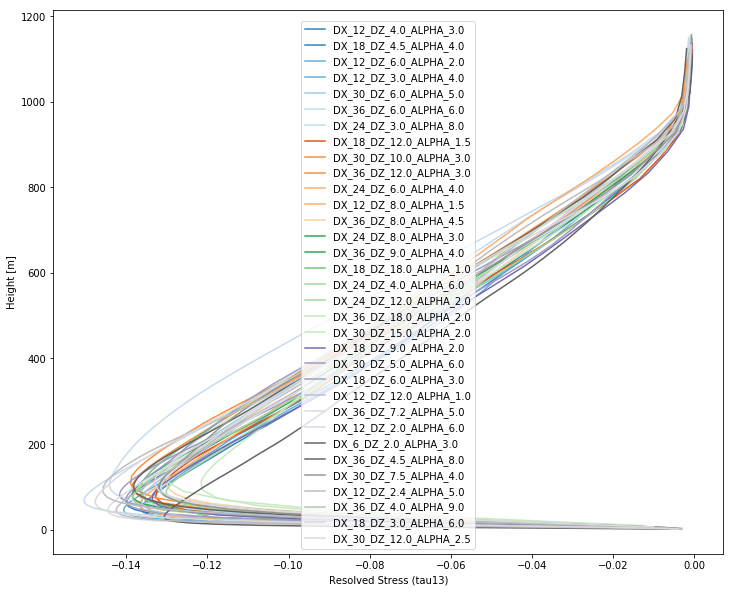

In [22]:
# Tau13 vertical profile, color a function of cases (one hour average)
f, ax = plt.subplots( figsize = (12, 10) )

for tt in range(0, len(cases)):
    ax.plot( ds_1hr[tt].isel(XTIME = 0).tau13, ds_1hr[tt].z , c = case_colormap[tt], label=f'{cases[tt]}' )
    
ax.set_xlabel('Resolved Stress (tau13)')
ax.set_ylabel('Height [m]')
ax.legend()


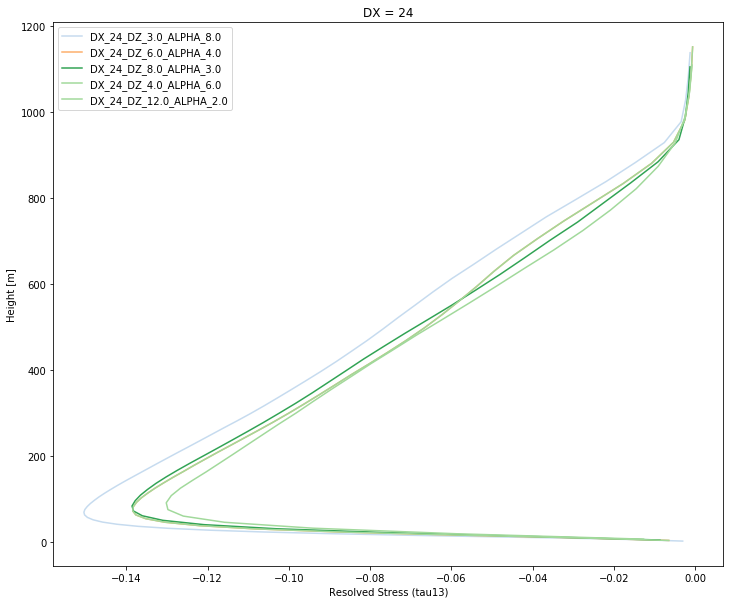

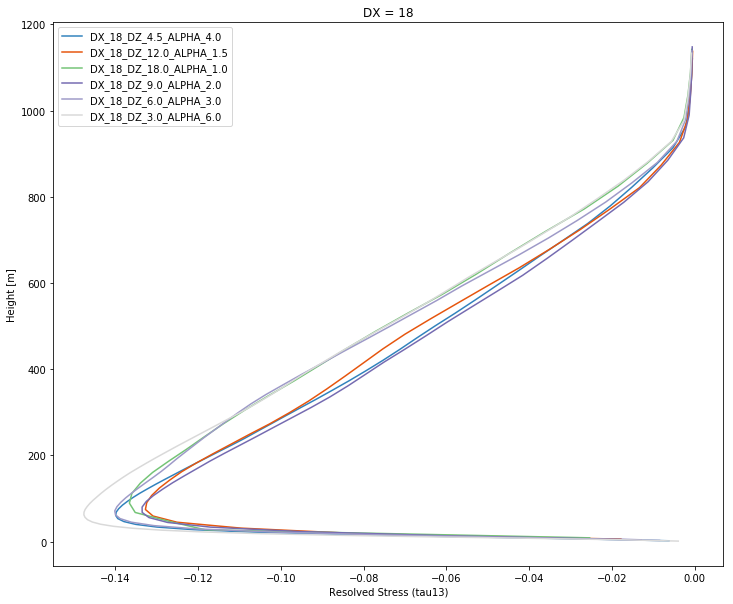

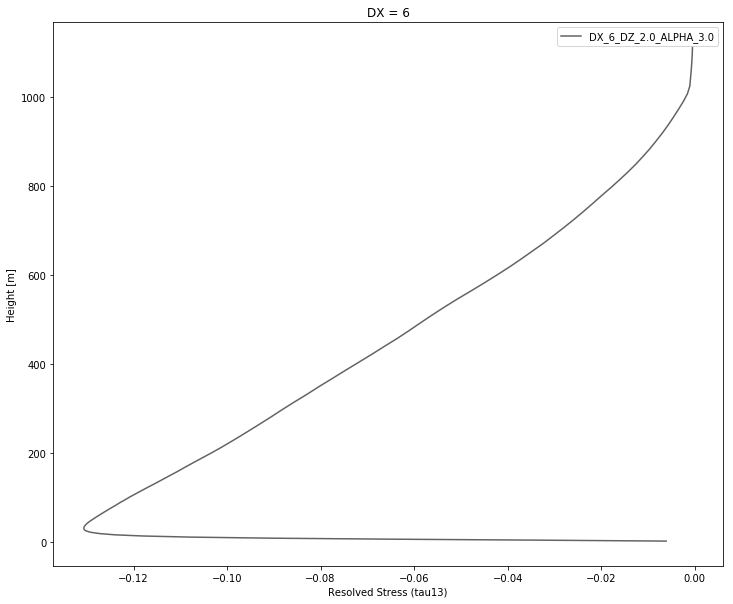

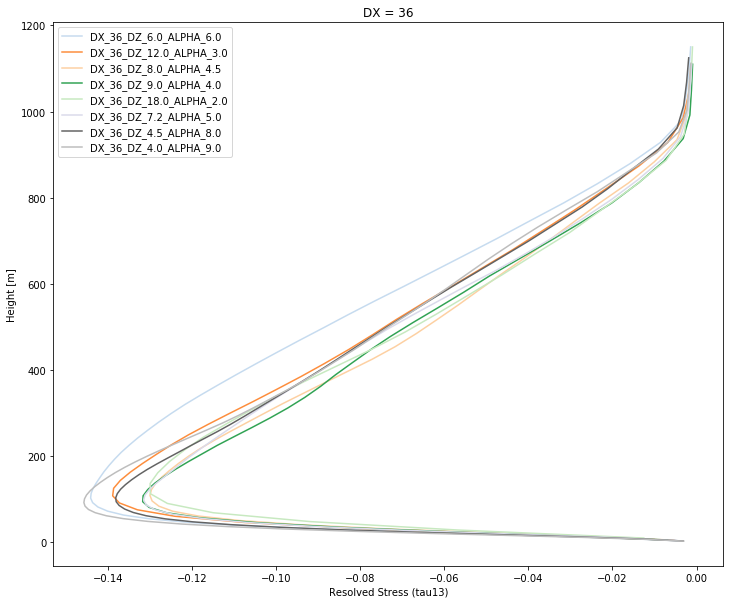

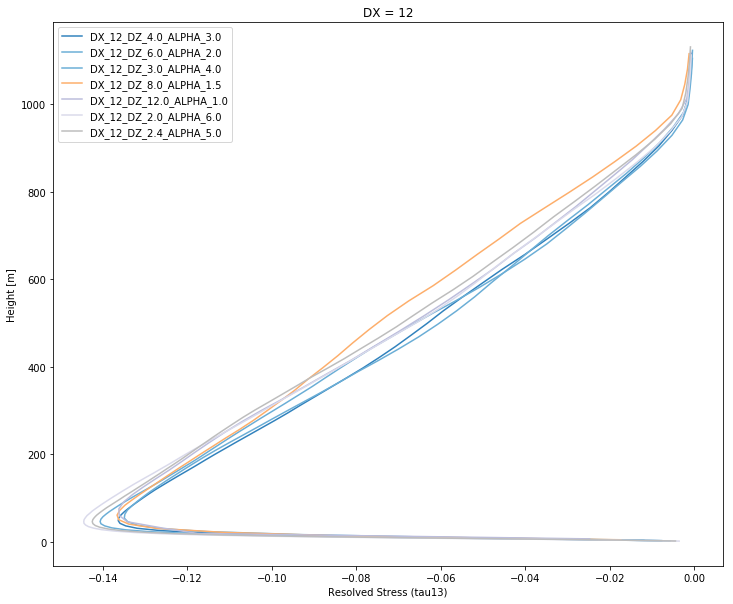

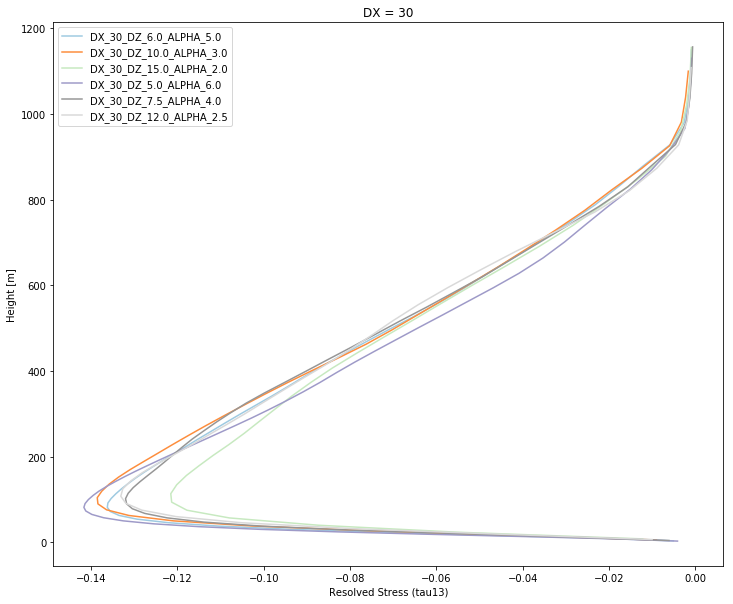

In [23]:
for dx_unique in DX_unique:
    plt.figure( figsize = (12, 10) )
    
    for tt in range(0, len(cases)):
        DX = cases[tt].split('_')[1]
        DZ = cases[tt].split('_')[3]
        
        #print(DX, dx_unique)
        if DX == dx_unique:   
            plt.plot( ds_1hr[tt].isel(XTIME = 0).tau13, ds_1hr[tt].z , c = case_colormap[tt], label=f'{cases[tt]}' )

    plt.xlabel('Resolved Stress (tau13)')
    plt.ylabel('Height [m]')
    plt.title('DX = {}'.format(dx_unique))
    plt.legend()

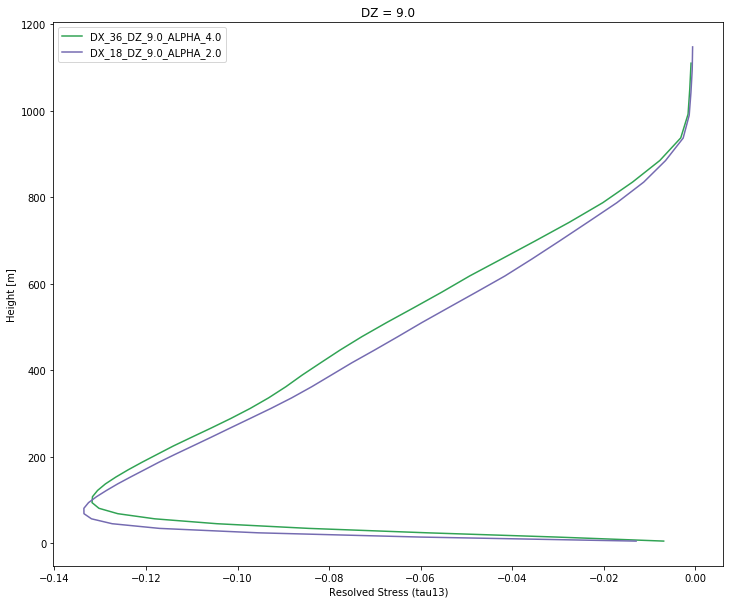

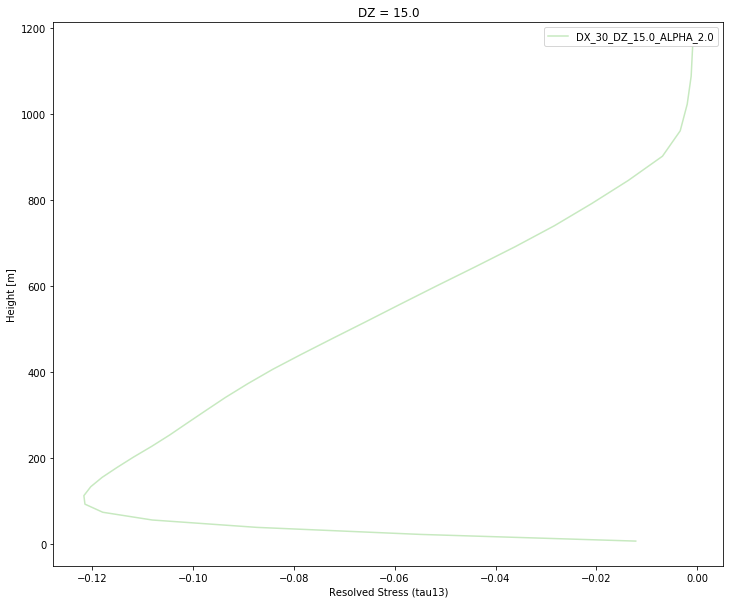

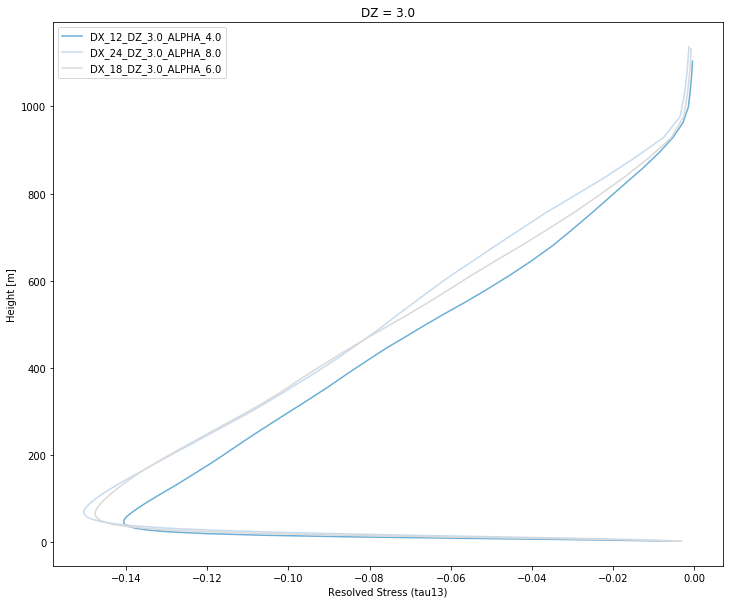

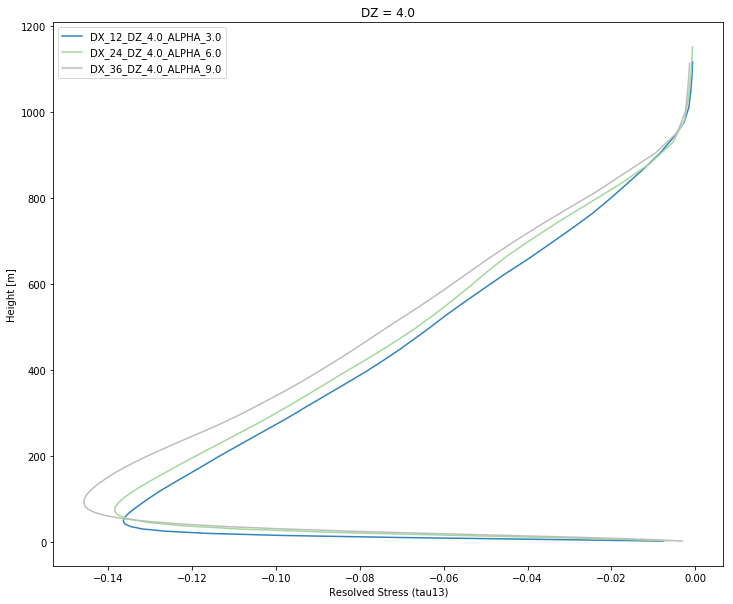

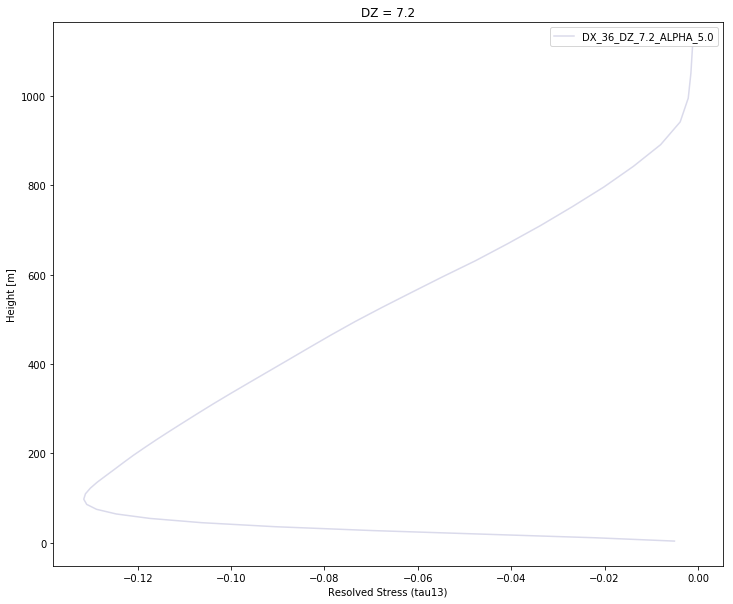

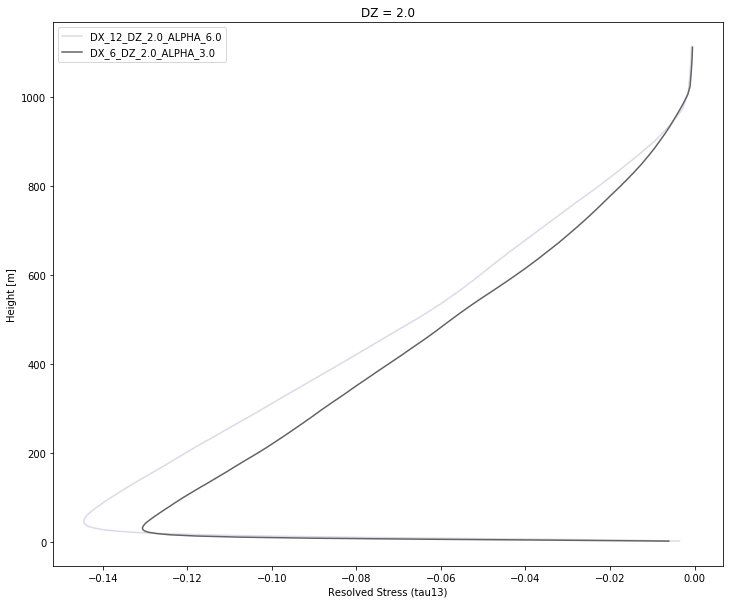

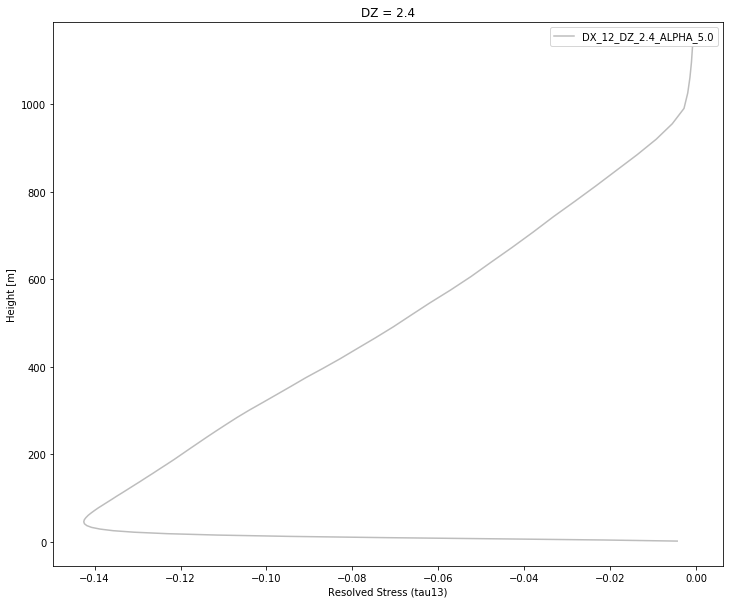

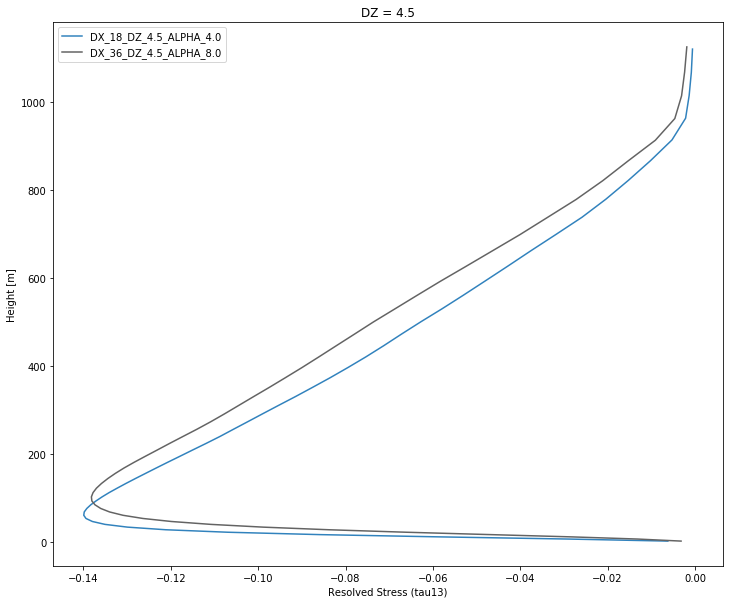

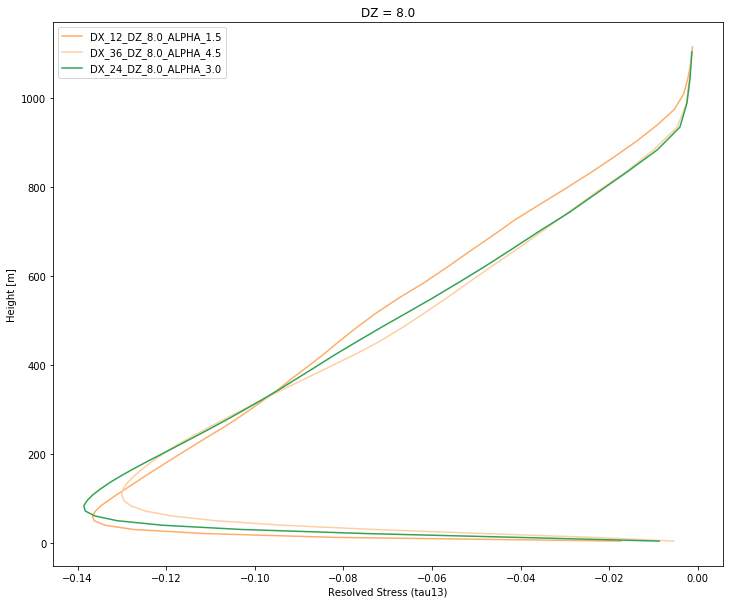

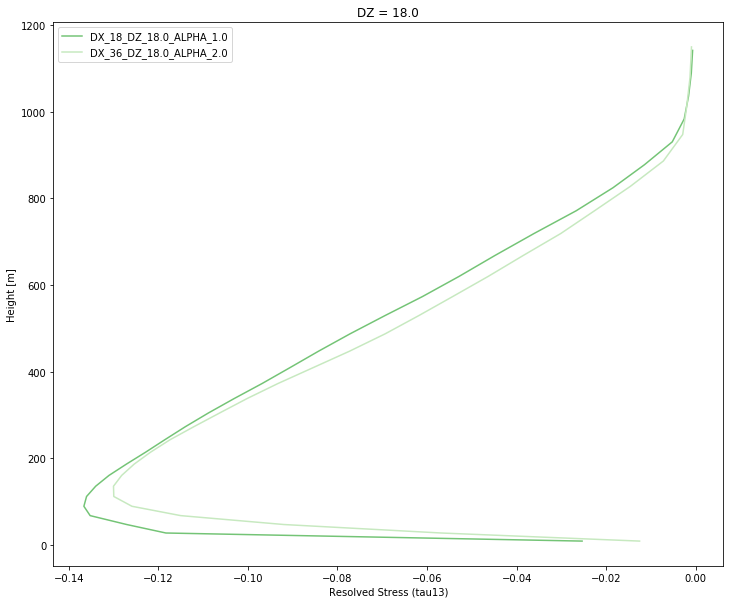

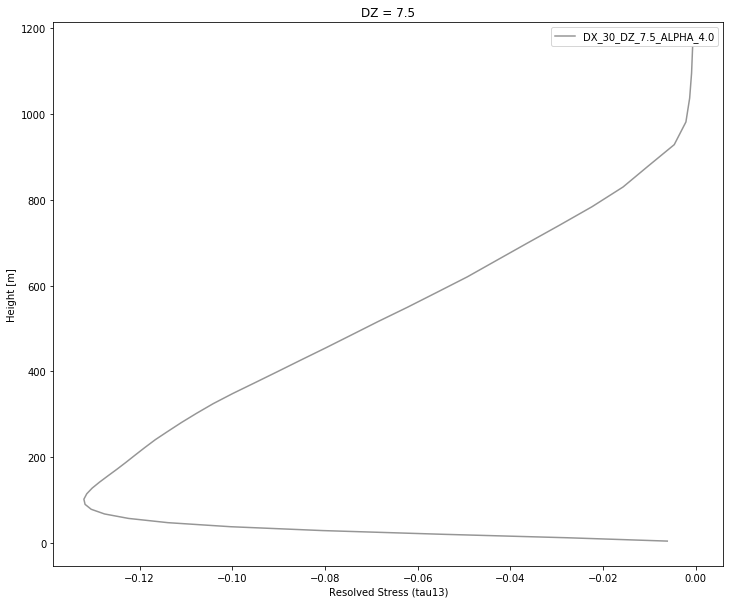

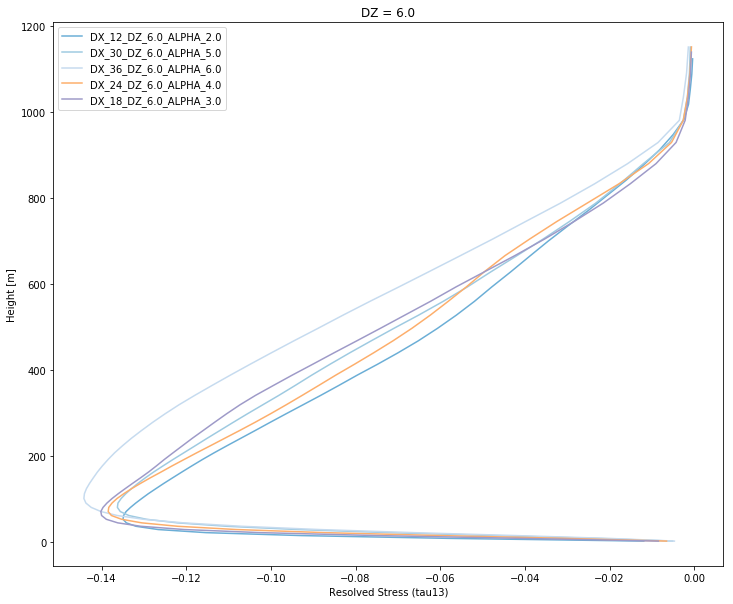

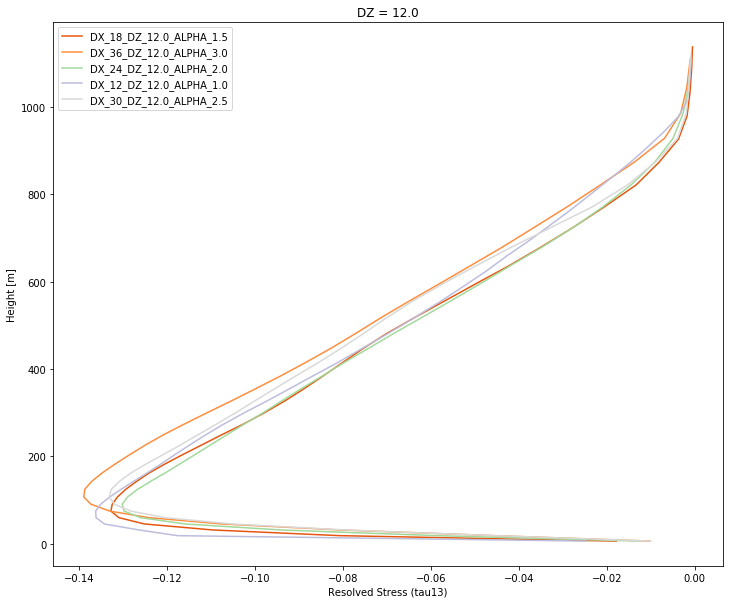

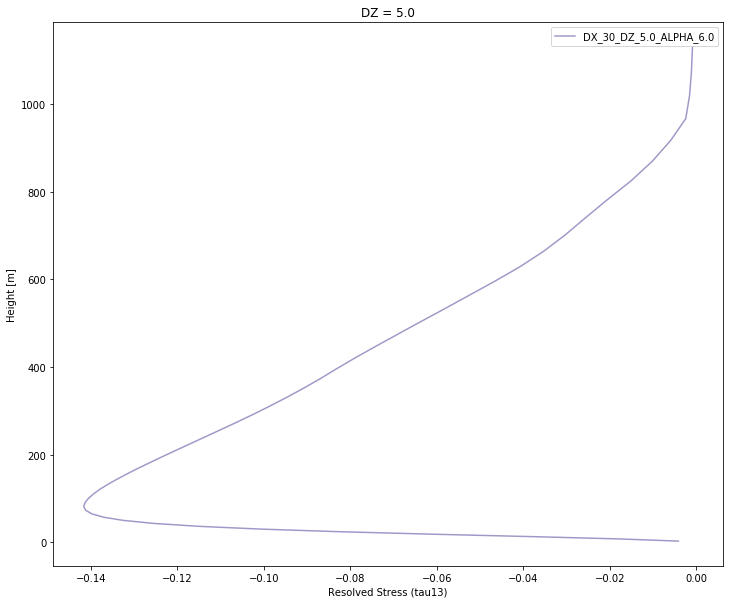

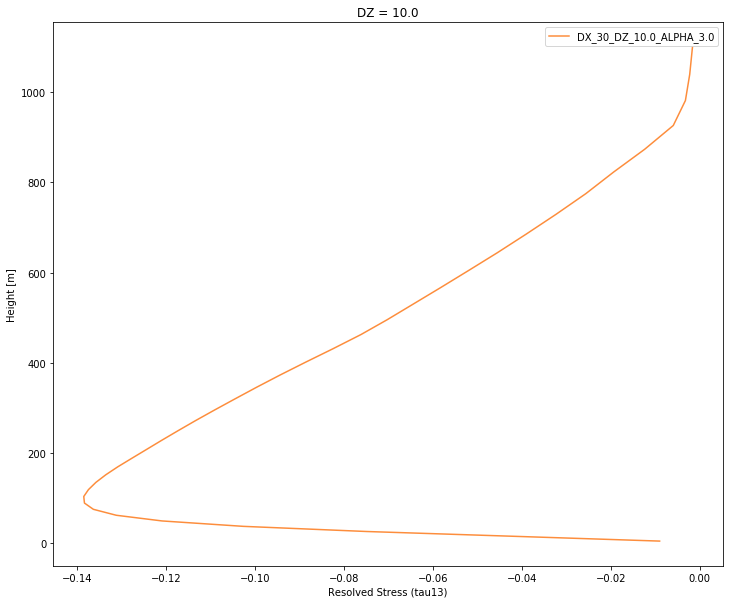

In [24]:
for dz_unique in DZ_unique:
    plt.figure( figsize = (12, 10) )
    
    for tt in range(0, len(cases)):
        DX = cases[tt].split('_')[1]
        DZ = cases[tt].split('_')[3]
        
        #print(DX, dx_unique)
        if DZ == dz_unique:   
            plt.plot( ds_1hr[tt].isel(XTIME = 0).tau13, ds_1hr[tt].z , c = case_colormap[tt], label=f'{cases[tt]}' )

    plt.xlabel('Resolved Stress (tau13)')
    plt.ylabel('Height [m]')
    plt.title('DZ = {}'.format(dz_unique))
    plt.legend()

(0.0, 200)

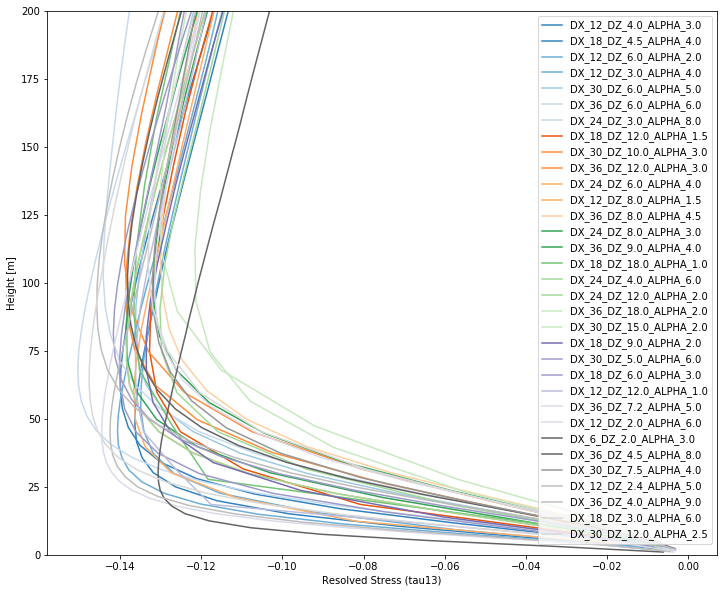

In [25]:
# Tau13 vertical profile, color a function of cases (one hour average)
f, ax = plt.subplots( figsize = (12, 10) )


for tt in range(0, len(cases)):
    ax.plot( ds_1hr[tt].isel(XTIME = 0).tau13, ds_1hr[tt].z , c = case_colormap[tt], label=f'{cases[tt]}' )
    
ax.set_xlabel('Resolved Stress (tau13)')
ax.set_ylabel('Height [m]')
ax.legend()


ax.set_ylim([0.,200])

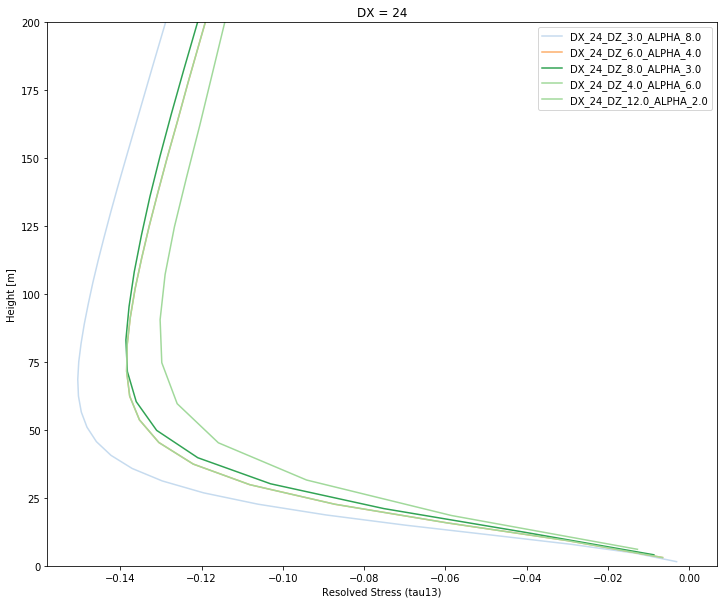

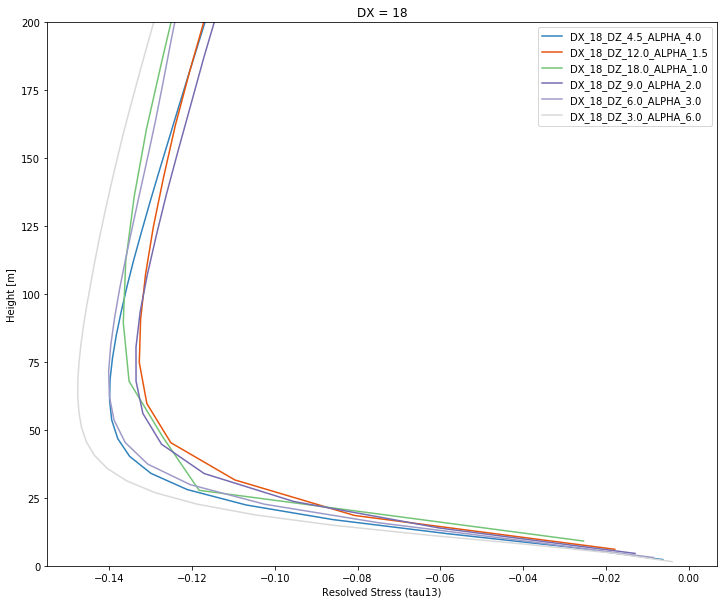

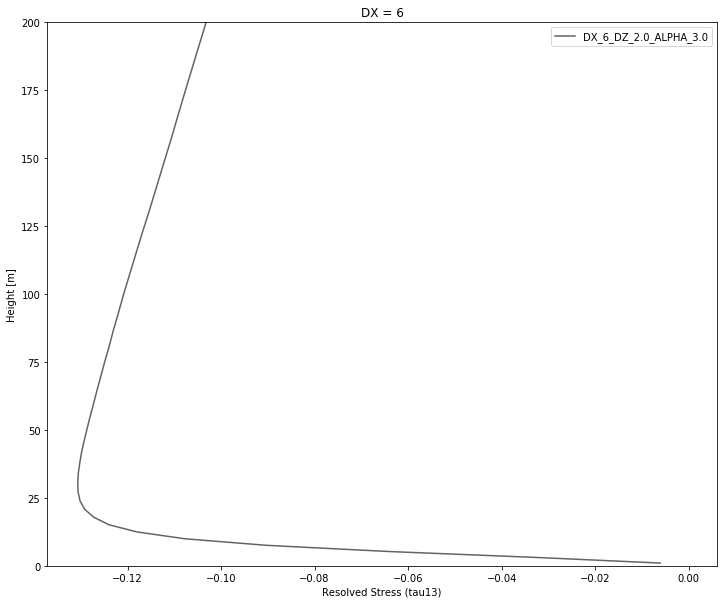

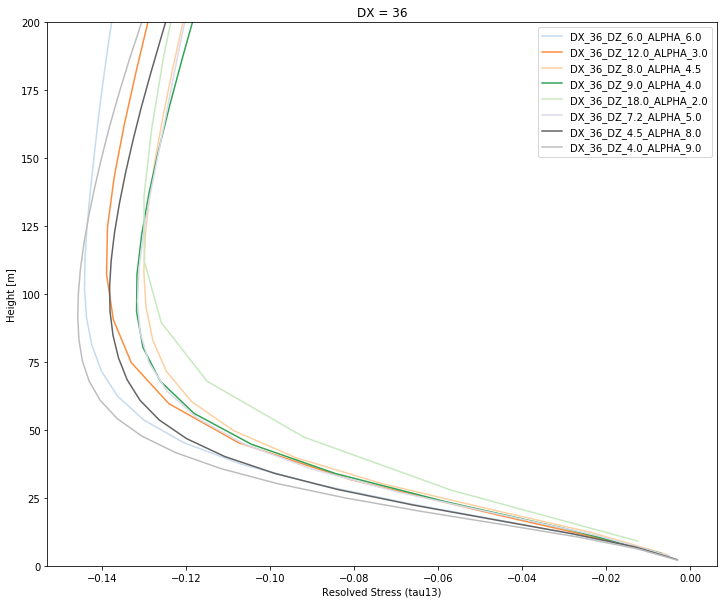

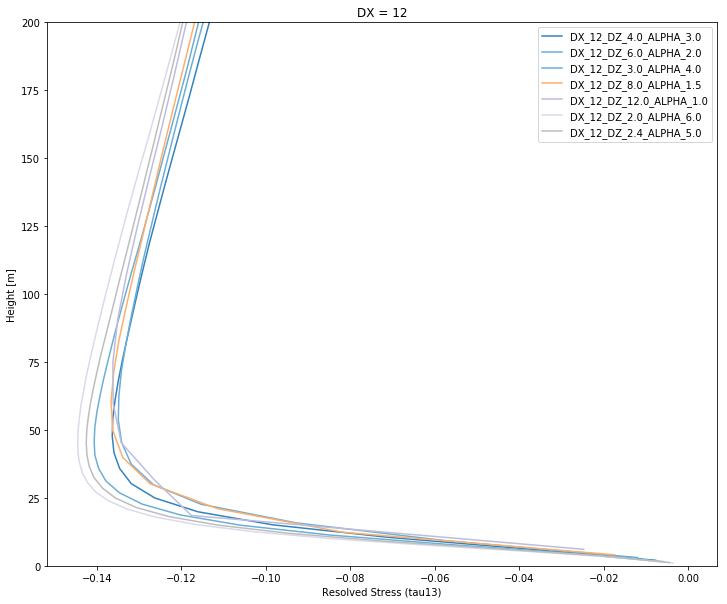

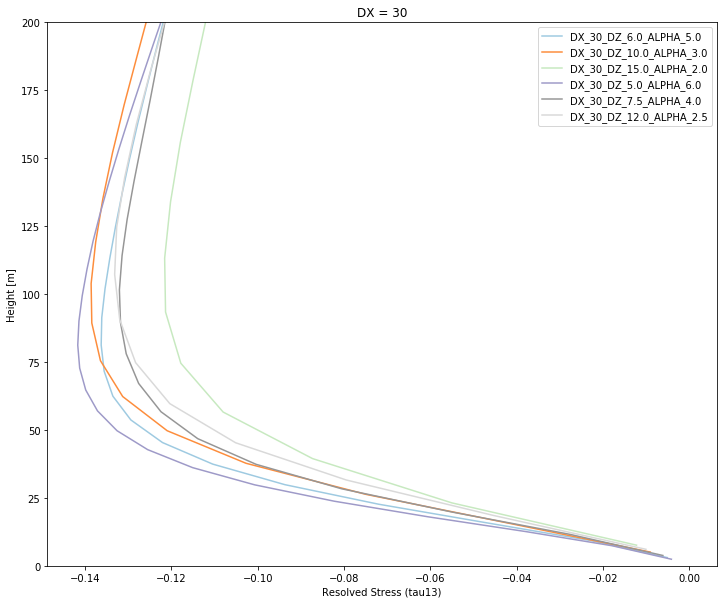

In [26]:
for dx_unique in DX_unique:
    plt.figure( figsize = (12, 10) )
    
    for tt in range(0, len(cases)):
        DX = cases[tt].split('_')[1]
        DZ = cases[tt].split('_')[3]
        
        #print(DX, dx_unique)
        if DX == dx_unique:   
            plt.plot( ds_1hr[tt].isel(XTIME = 0).tau13, ds_1hr[tt].z , c = case_colormap[tt], label=f'{cases[tt]}' )

    plt.xlabel('Resolved Stress (tau13)')
    plt.ylabel('Height [m]')
    plt.title('DX = {}'.format(dx_unique))
    plt.legend()
    
    plt.ylim([0.,200])

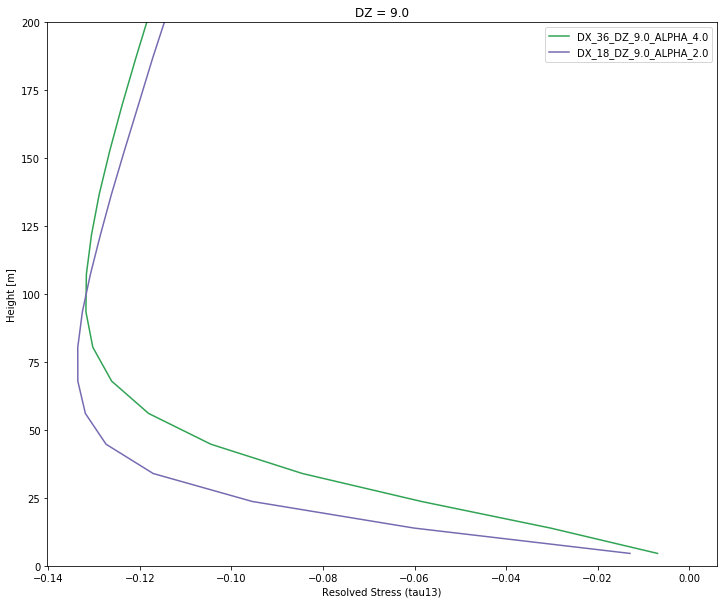

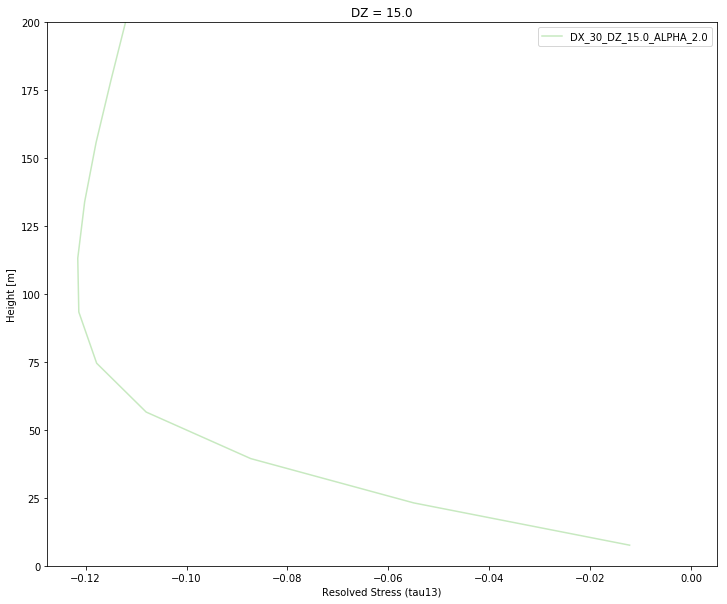

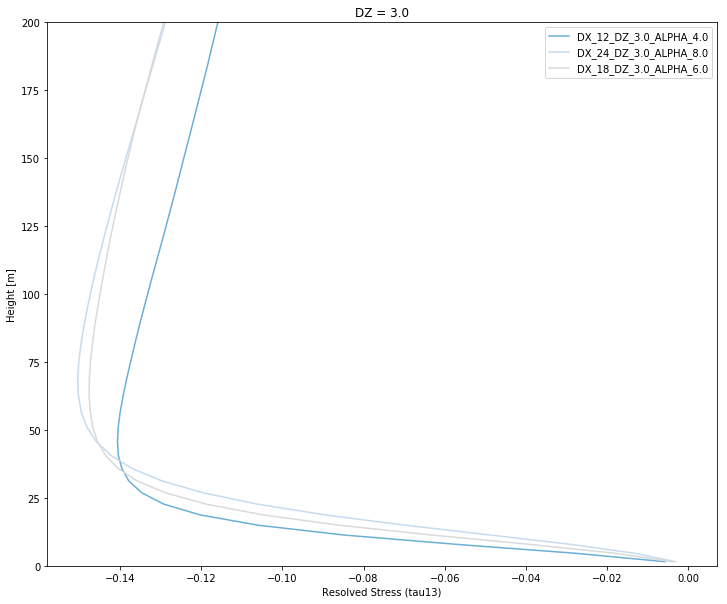

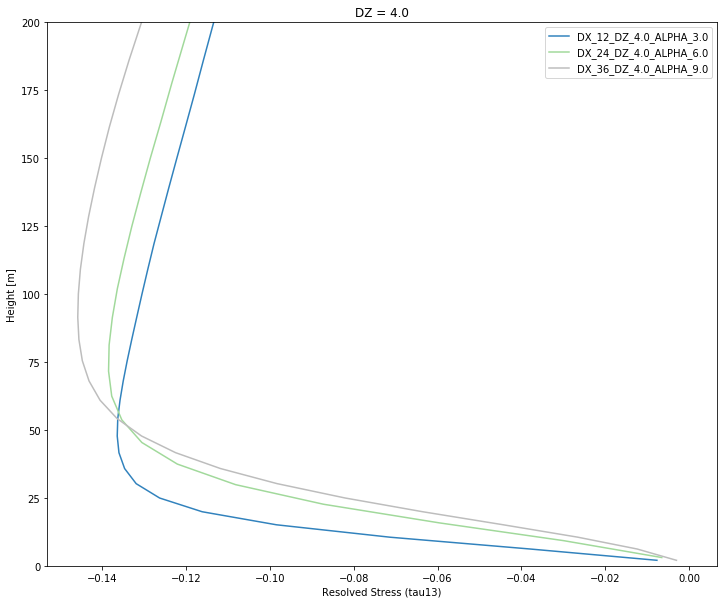

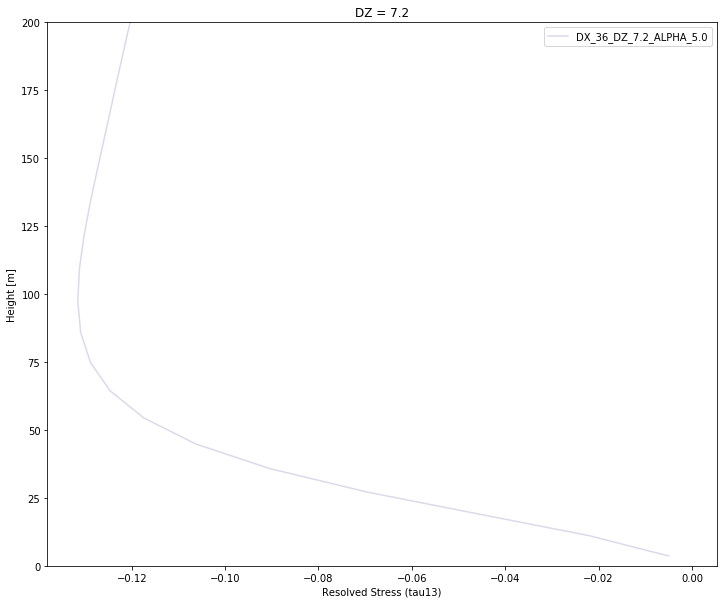

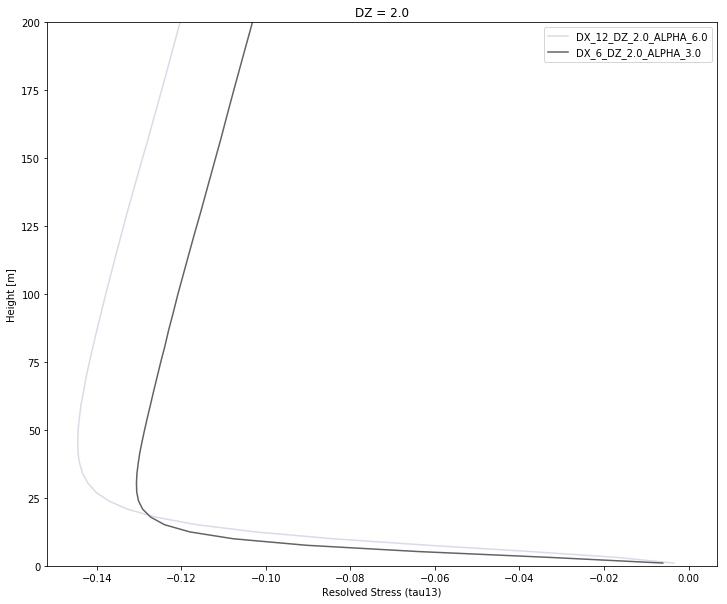

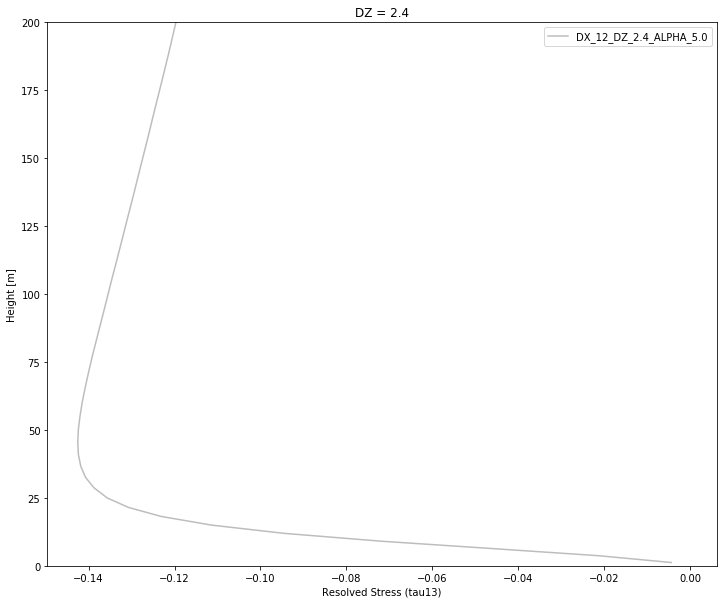

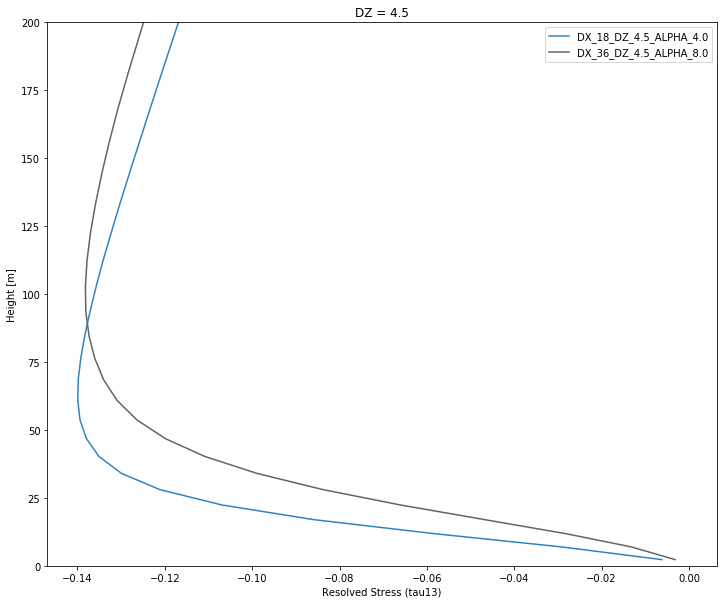

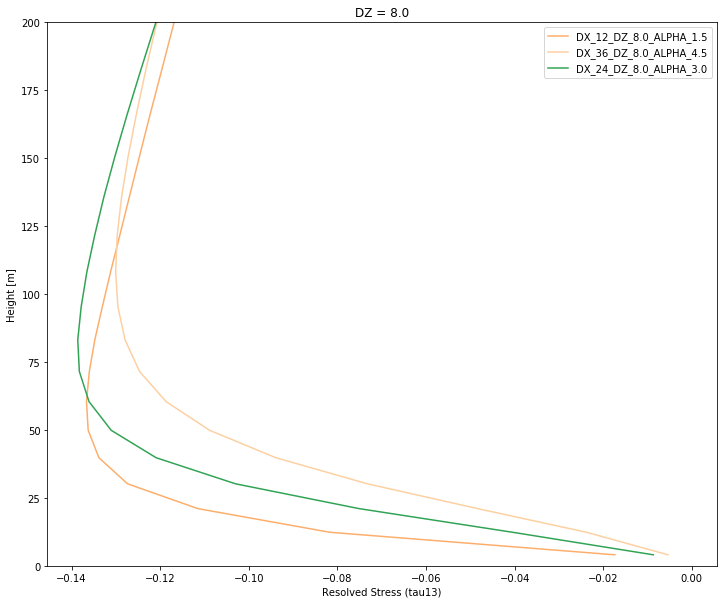

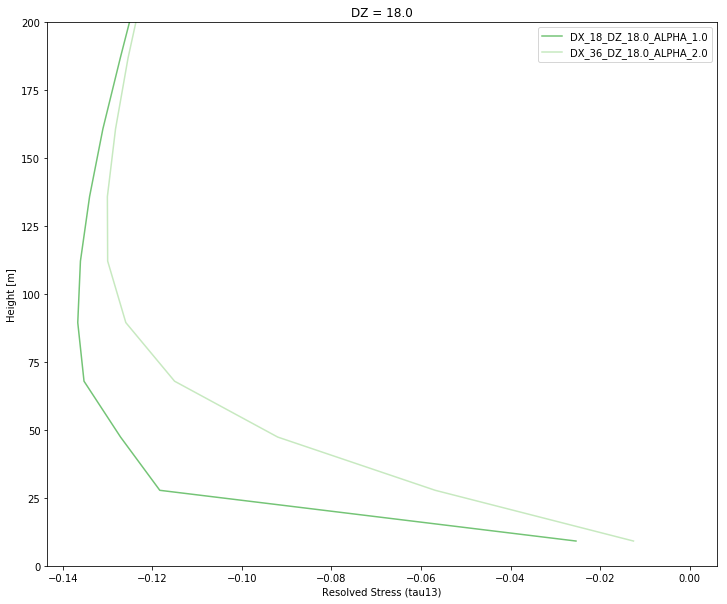

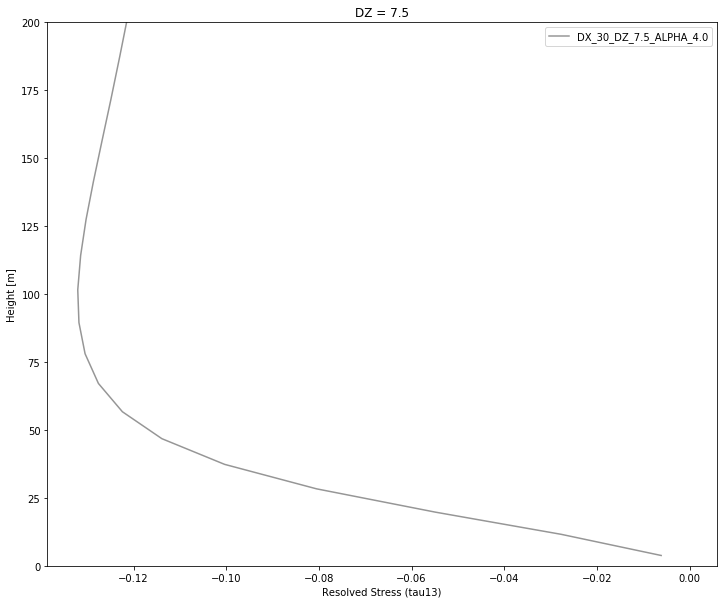

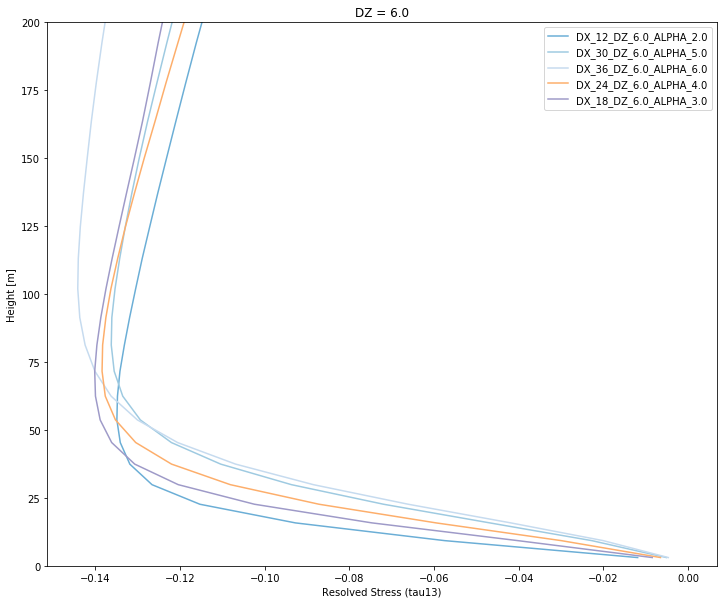

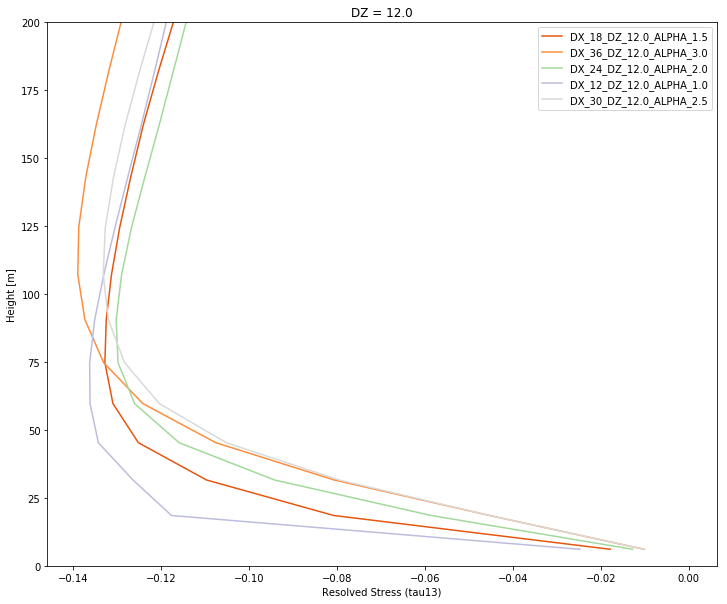

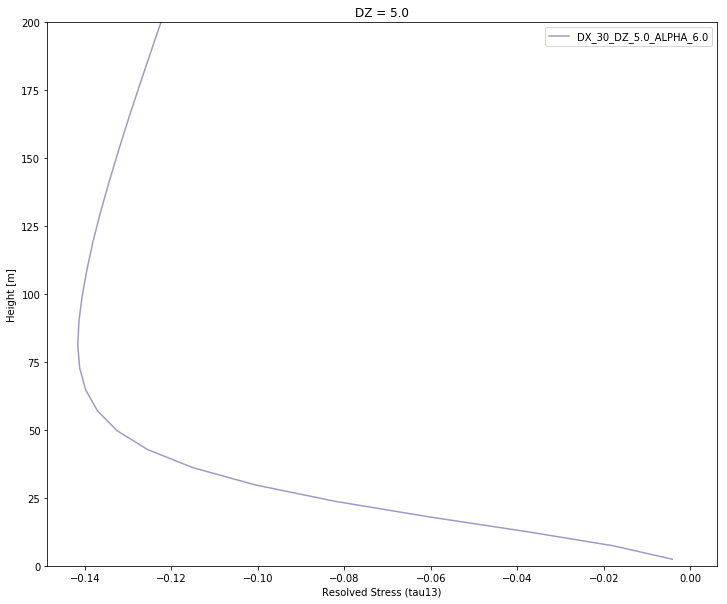

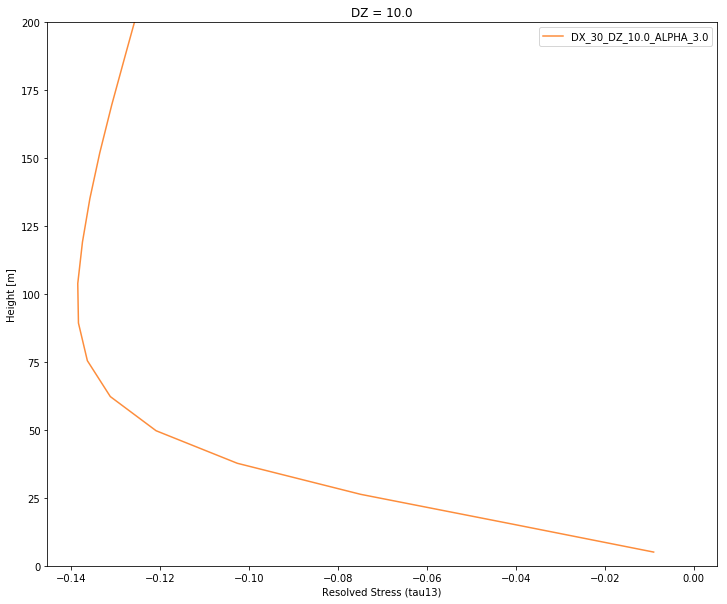

In [27]:
for dz_unique in DZ_unique:
    plt.figure( figsize = (12, 10) )
    
    for tt in range(0, len(cases)):
        DX = cases[tt].split('_')[1]
        DZ = cases[tt].split('_')[3]
        
        #print(DX, dx_unique)
        if DZ == dz_unique:   
            plt.plot( ds_1hr[tt].isel(XTIME = 0).tau13, ds_1hr[tt].z , c = case_colormap[tt], label=f'{cases[tt]}' )

    plt.xlabel('Resolved Stress (tau13)')
    plt.ylabel('Height [m]')
    plt.title('DZ = {}'.format(dz_unique))
    plt.legend()
    
    plt.ylim([0.,200])

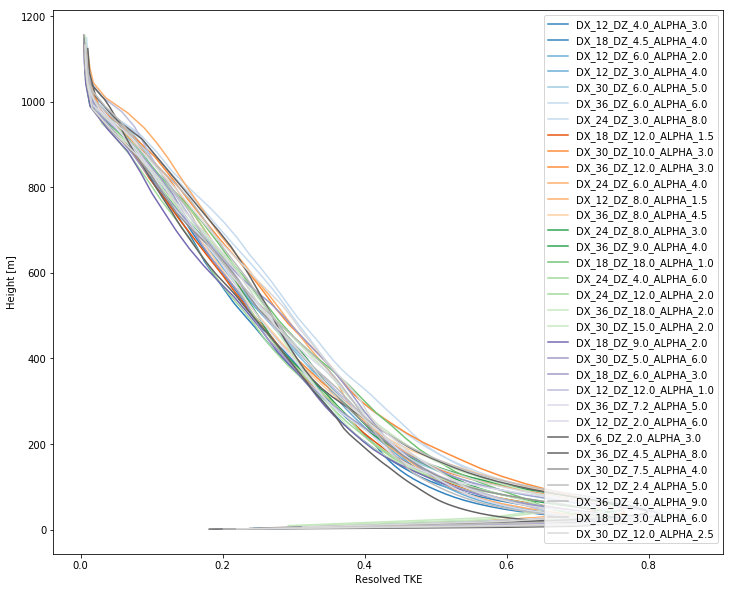

In [28]:
# TKE vertical profile, color a function of cases (one hour average)
f, ax = plt.subplots( figsize = (12, 10) )

for tt in range(0, len(cases)): 
    ax.plot( ds_1hr[tt].isel(XTIME = 0).TKE, ds_1hr[tt].z , c = case_colormap[tt], label=f'{cases[tt]}')
    
ax.set_xlabel('Resolved TKE')
ax.set_ylabel('Height [m]')
ax.legend()

(0.0, 200)

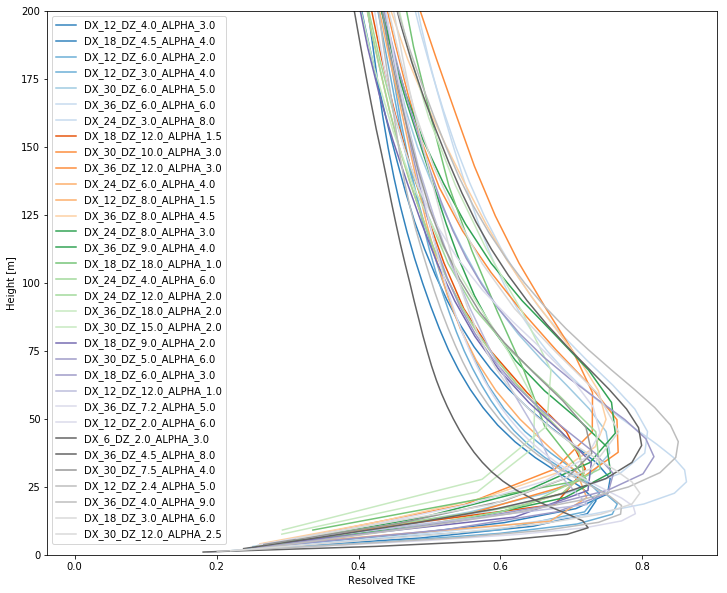

In [29]:
# TKE vertical profile, color a function of cases (one hour average)
f, ax = plt.subplots( figsize = (12, 10) )

for tt in range(0, len(cases)): 
    ax.plot( ds_1hr[tt].isel(XTIME = 0).TKE, ds_1hr[tt].z , c = case_colormap[tt], label=f'{cases[tt]}')
    
ax.set_xlabel('Resolved TKE')
ax.set_ylabel('Height [m]')
ax.legend()

ax.set_ylim([0., 200])

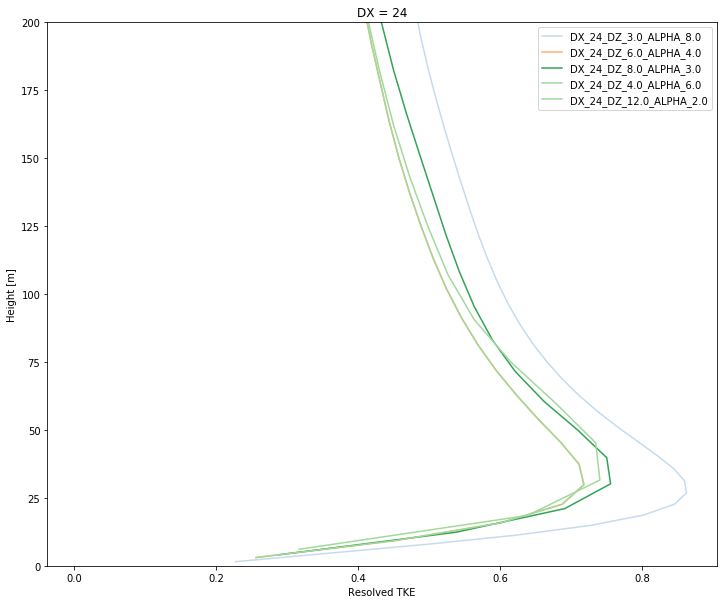

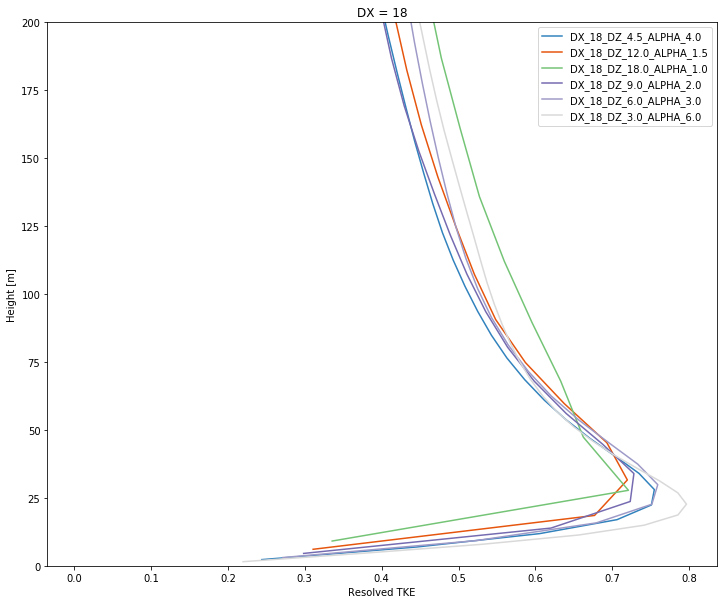

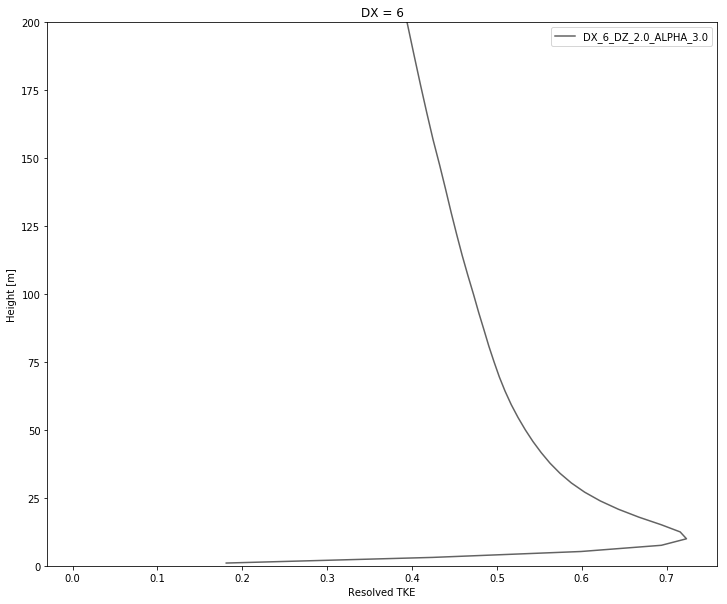

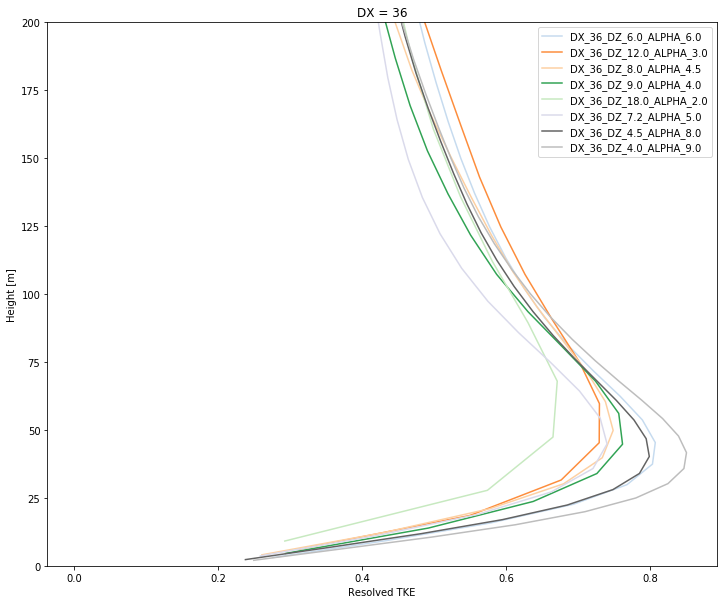

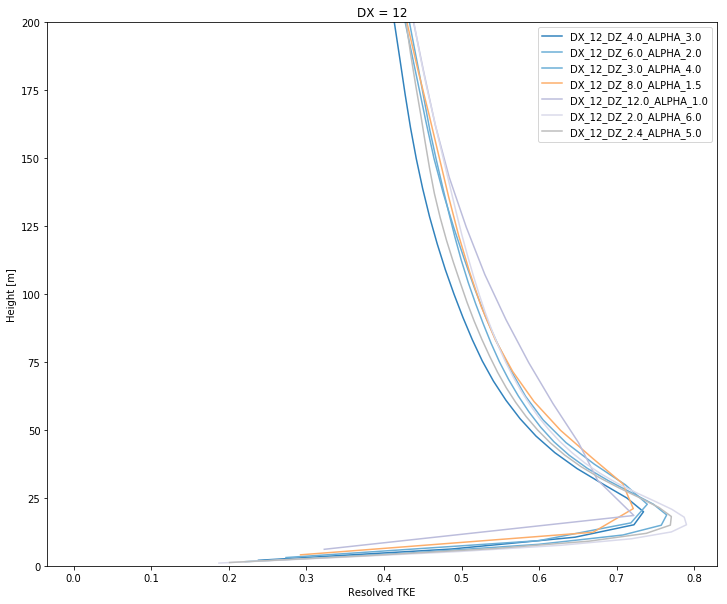

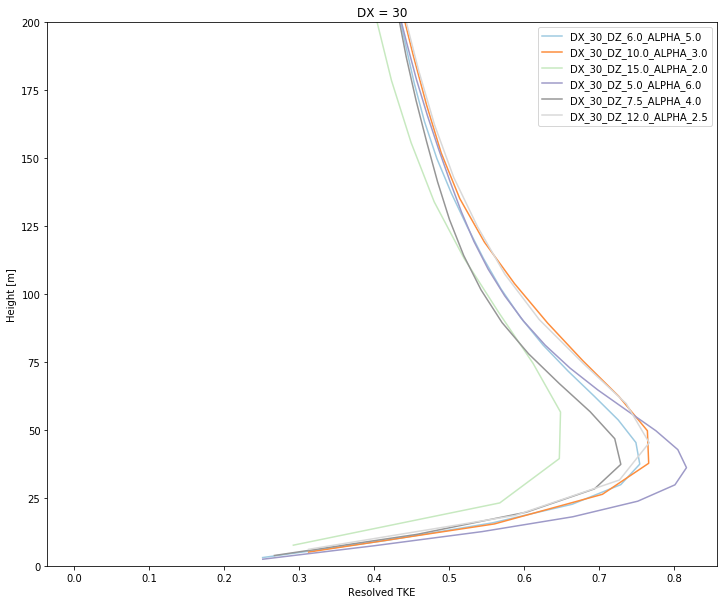

In [30]:
for dx_unique in DX_unique:
    plt.figure( figsize = (12, 10) )
    
    for tt in range(0, len(cases)):
        DX = cases[tt].split('_')[1]
        DZ = cases[tt].split('_')[3]
        
        #print(DX, dx_unique)
        if DX == dx_unique:   
            plt.plot( ds_1hr[tt].isel(XTIME = 0).TKE, ds_1hr[tt].z , c = case_colormap[tt], label=f'{cases[tt]}' )

    plt.xlabel('Resolved TKE')
    plt.ylabel('Height [m]')
    plt.title('DX = {}'.format(dx_unique))
    plt.legend()
    
    plt.ylim([0.,200])

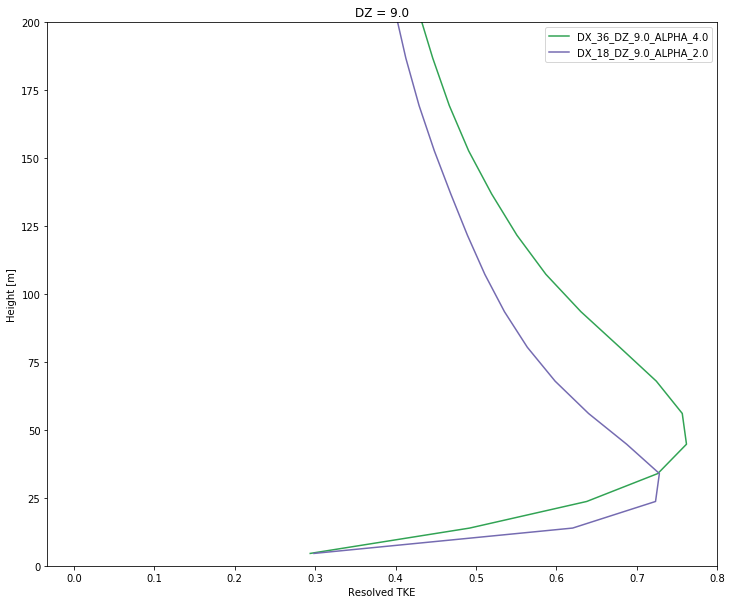

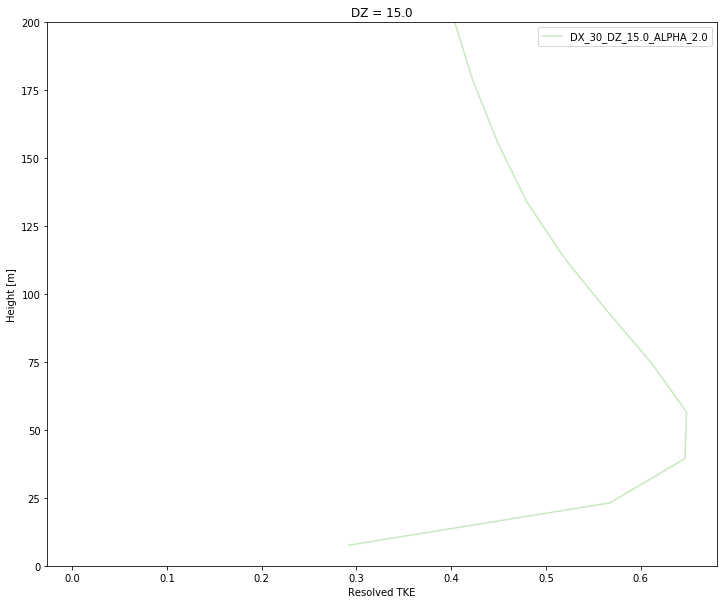

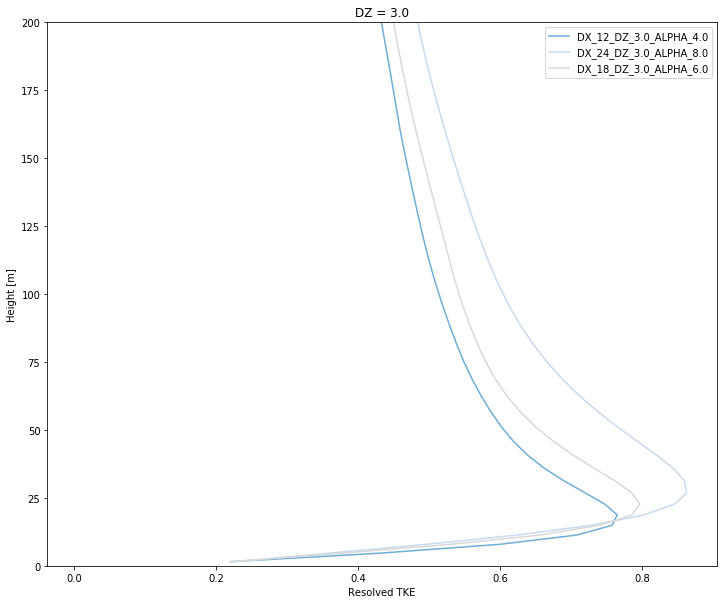

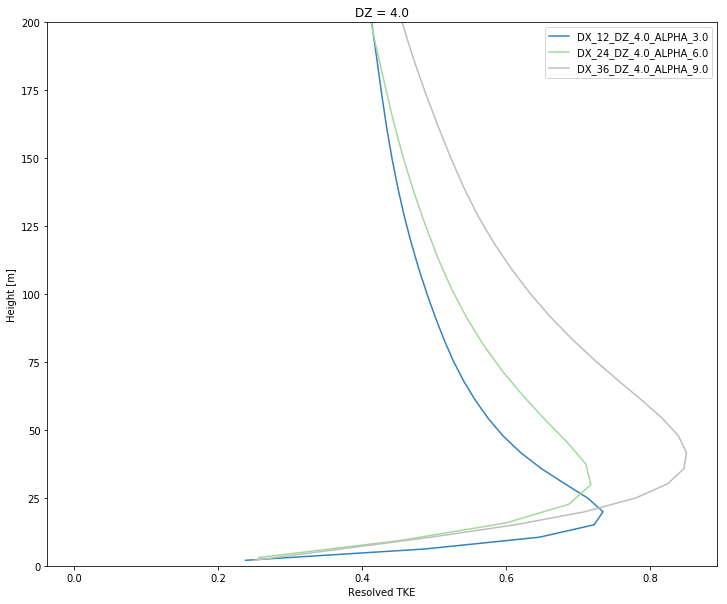

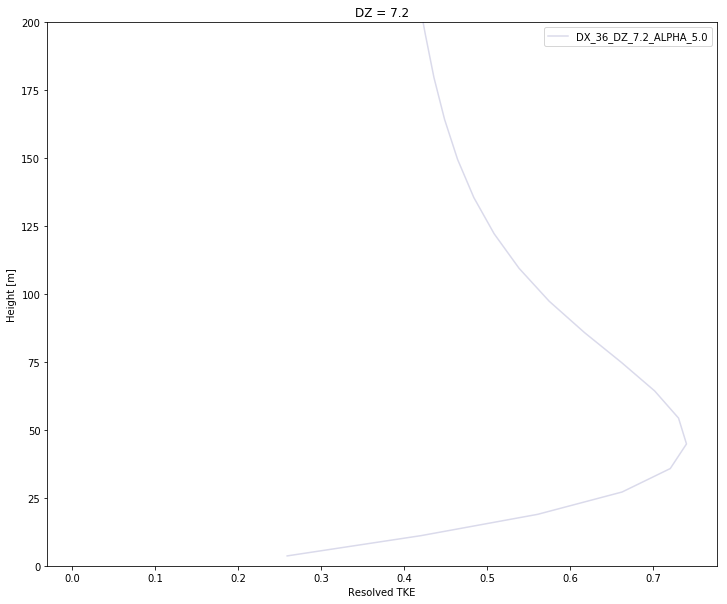

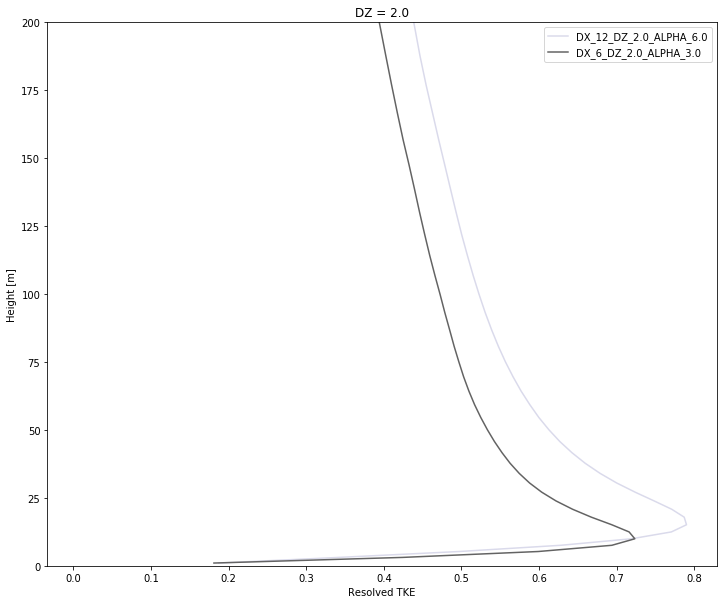

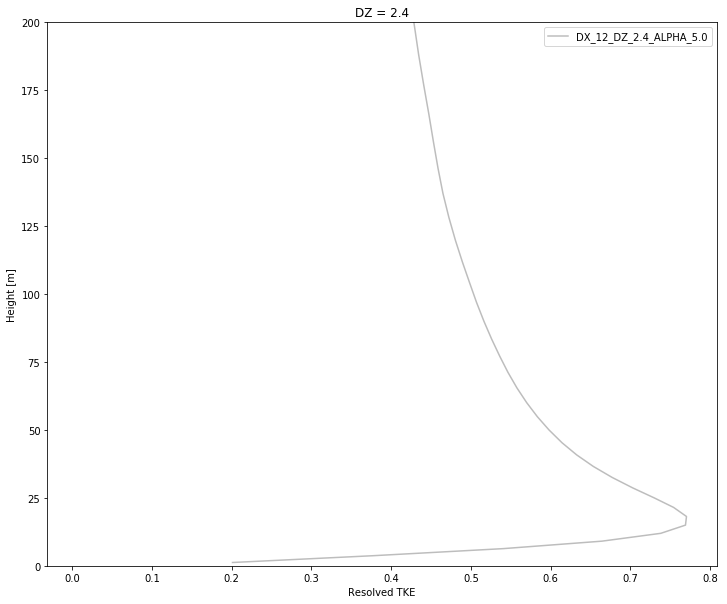

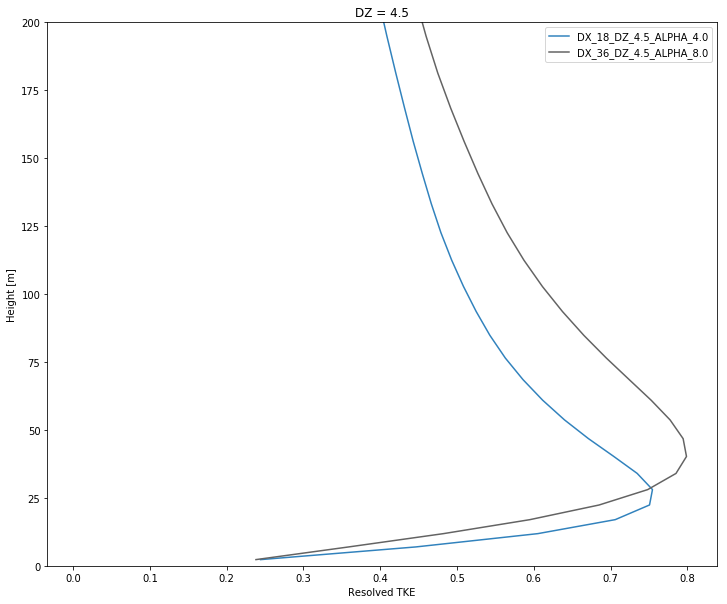

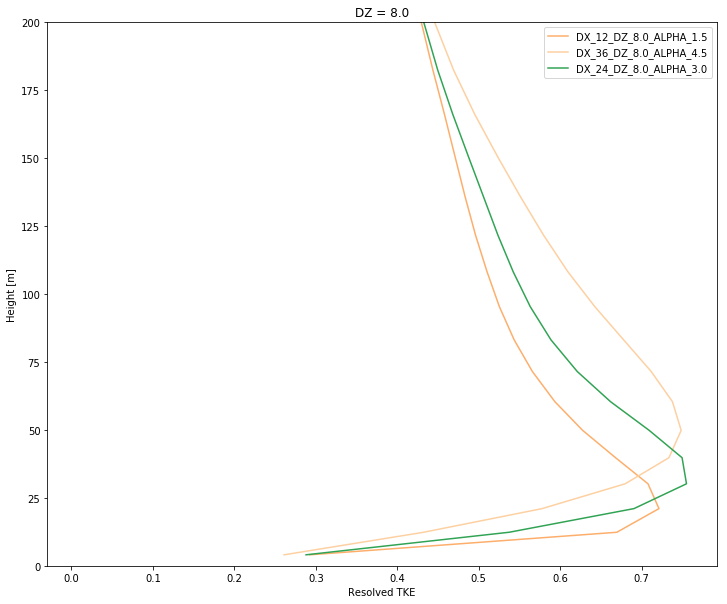

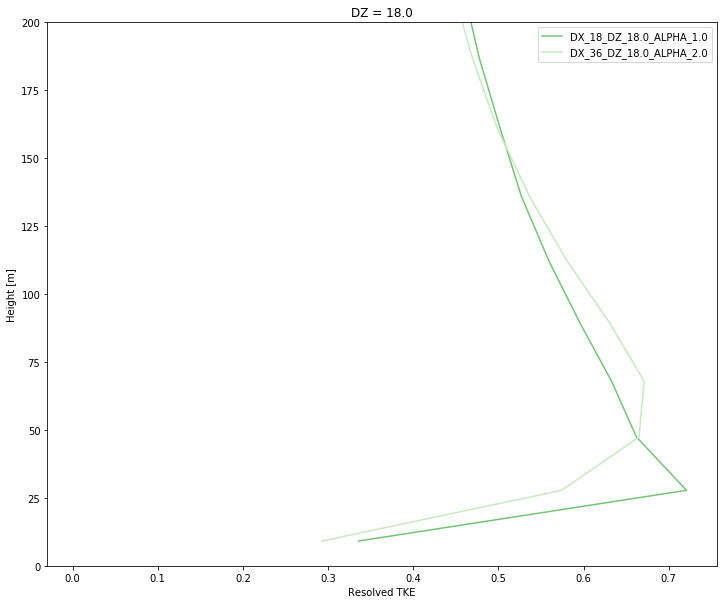

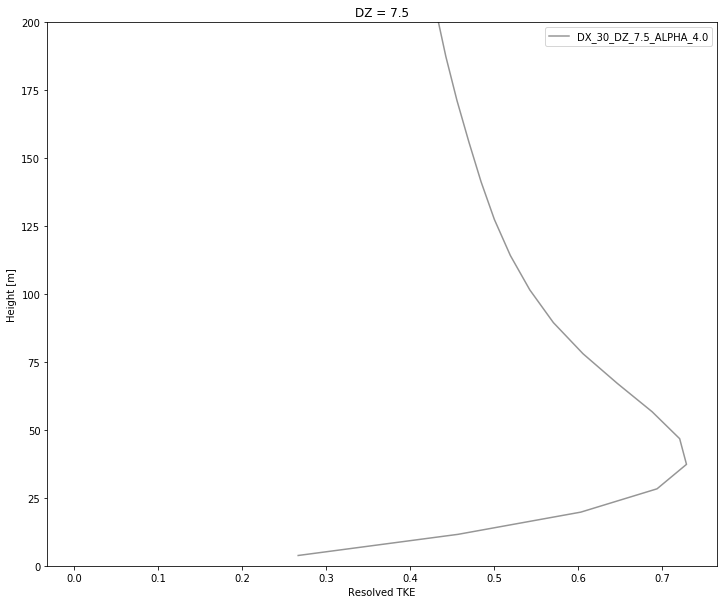

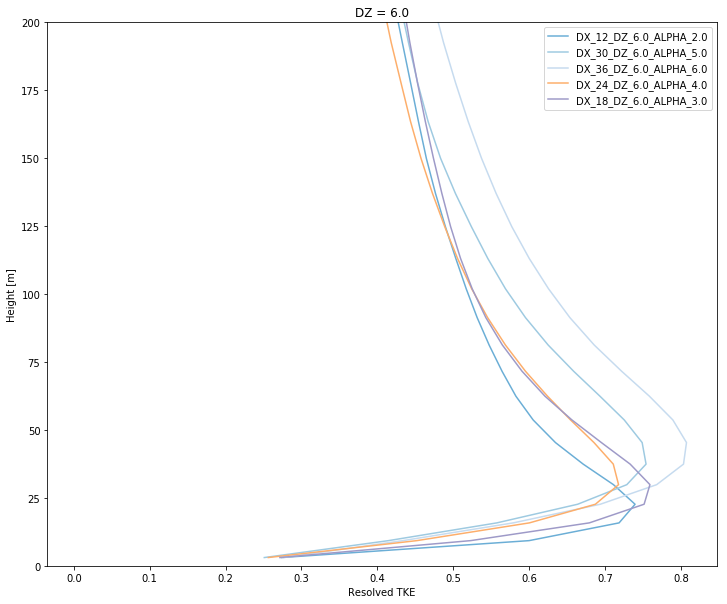

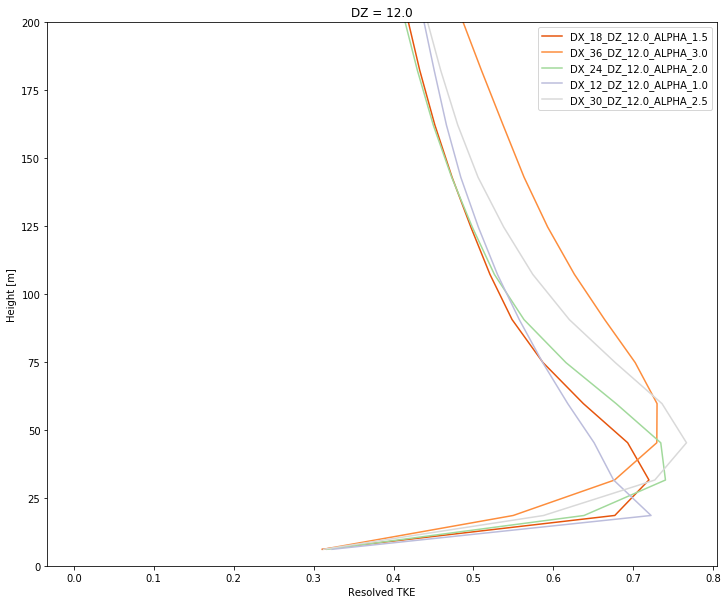

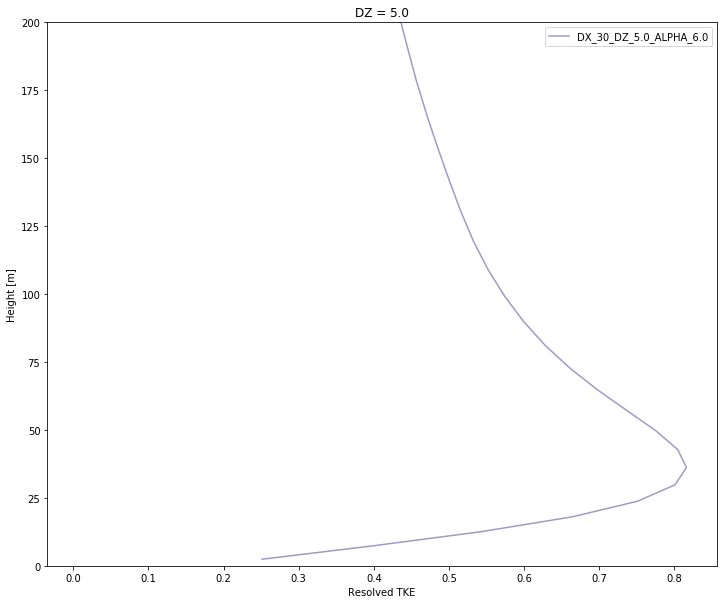

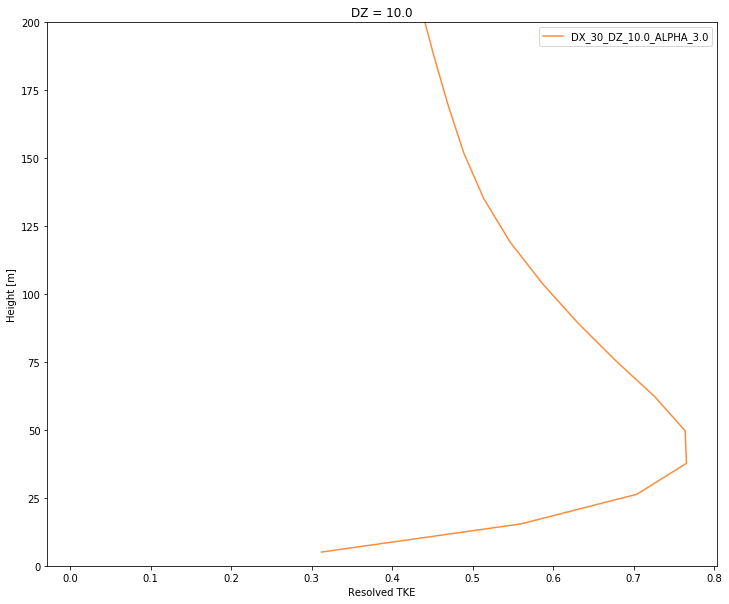

In [31]:
for dz_unique in DZ_unique:
    plt.figure( figsize = (12, 10) )
    
    for tt in range(0, len(cases)):
        DX = cases[tt].split('_')[1]
        DZ = cases[tt].split('_')[3]
        
        #print(DX, dx_unique)
        if DZ == dz_unique:   
            plt.plot( ds_1hr[tt].isel(XTIME = 0).TKE, ds_1hr[tt].z , c = case_colormap[tt], label=f'{cases[tt]}' )

    plt.xlabel('Resolved TKE')
    plt.ylabel('Height [m]')
    plt.title('DZ = {}'.format(dz_unique))
    plt.legend()
    
    plt.ylim([0.,200])

### Spectra

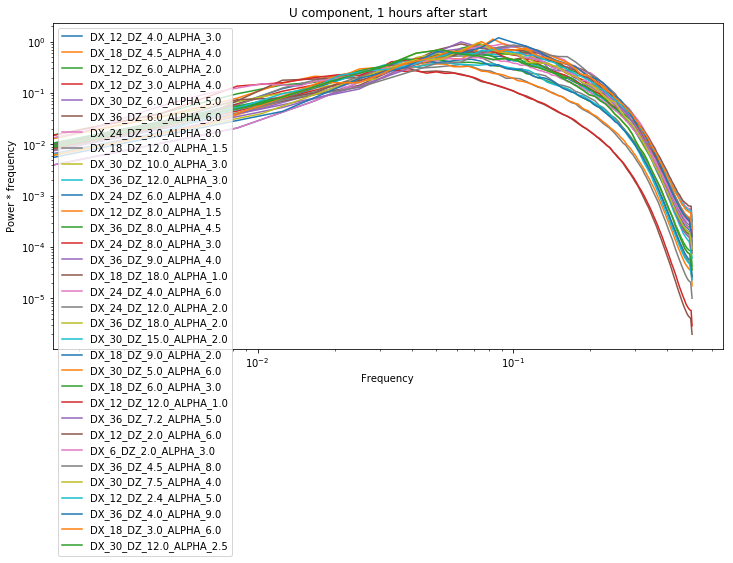

In [32]:
#Spectra after one hour a function of cases
tind = 1
f, ax  = plt.subplots(figsize = ( 12, 6) )

z_spectra=0 #first level

for tt in range(0, len(cases)): 
    z_spectra = psd_ds_1hr[tt].z.isel(XTIME = 0)
    psd_ds_1hr[tt]['U_p_norm_power'] = psd_ds_1hr[tt].U_p * psd_ds_1hr[tt].frequency
    psd_ds_1hr[tt]['W_p_norm_power'] = psd_ds_1hr[tt].W_p * psd_ds_1hr[tt].frequency
    ax.plot( psd_ds_1hr[tt].frequency, psd_ds_1hr[tt].U_p_norm_power.isel(XTIME = 0, nz = 0),\
            label = f'{cases[tt]}' )

ax.set_ylabel('Power * frequency')    
ax.set_xlabel('Frequency')

ax.set_title(f"U component, {tind} hours after start")

ax.set_xscale('log')
ax.set_yscale('log')

ax.legend(loc = 'best')


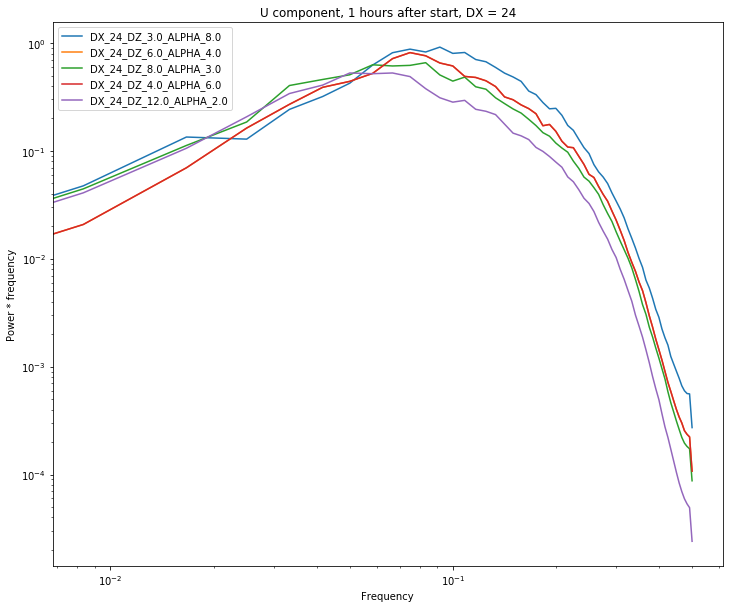

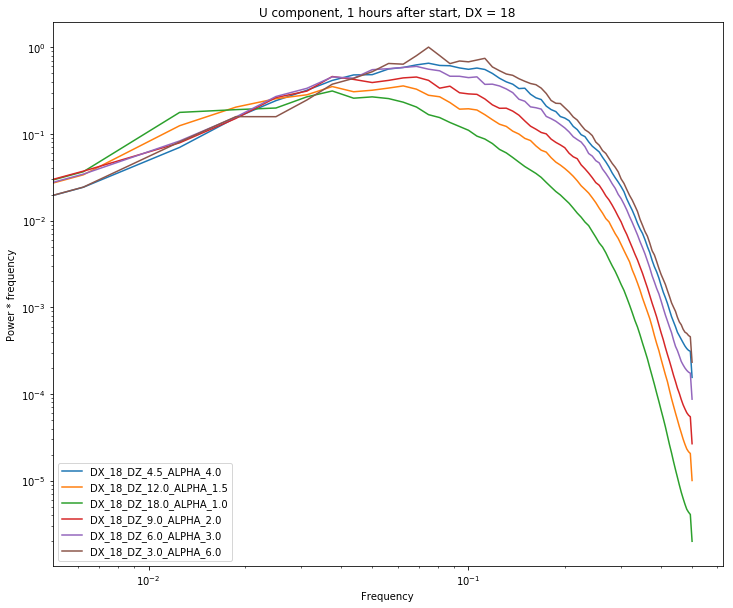

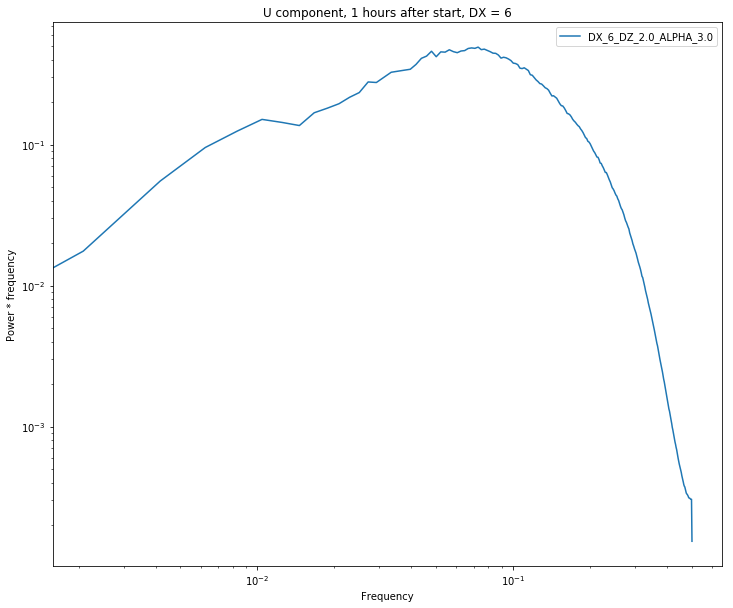

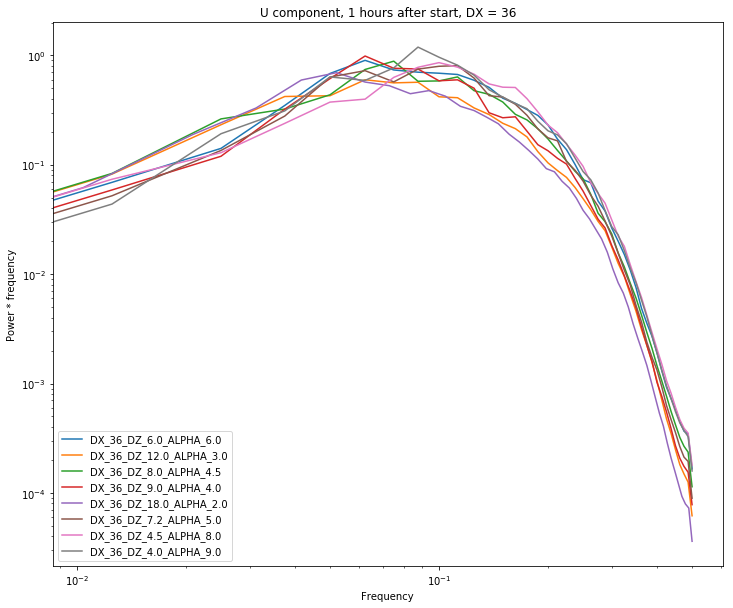

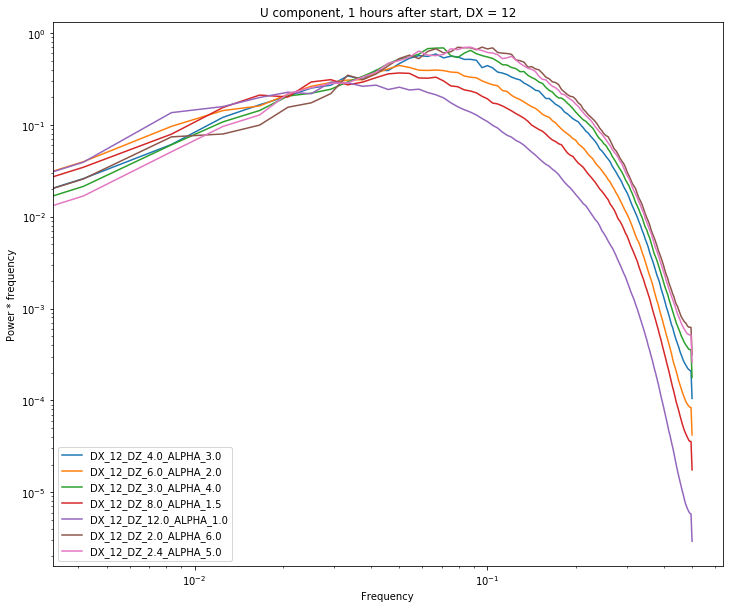

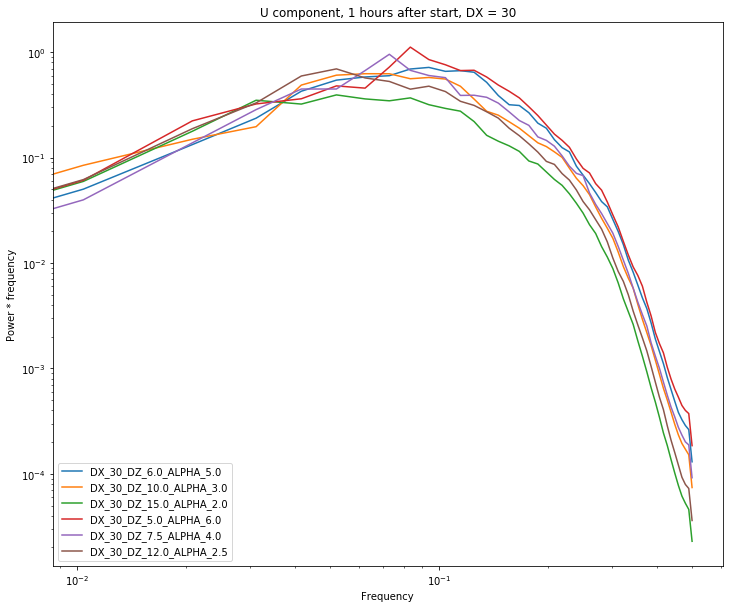

In [33]:
#Spectra after one hour a function of cases
for dx_unique in DX_unique:
    plt.figure( figsize = (12, 10) )
    tind = 1

    z_spectra=0 #first level

    for tt in range(0, len(cases)):
        DX = cases[tt].split('_')[1]
        DZ = cases[tt].split('_')[3]
        
        if DX == dx_unique:
            z_spectra = psd_ds_1hr[tt].z.isel(XTIME = 0)
            psd_ds_1hr[tt]['U_p_norm_power'] = psd_ds_1hr[tt].U_p * psd_ds_1hr[tt].frequency
            psd_ds_1hr[tt]['W_p_norm_power'] = psd_ds_1hr[tt].W_p * psd_ds_1hr[tt].frequency
            plt.plot( psd_ds_1hr[tt].frequency, psd_ds_1hr[tt].U_p_norm_power.isel(XTIME = 0, nz = 0),\
                    label = f'{cases[tt]}' )

    plt.ylabel('Power * frequency')    
    plt.xlabel('Frequency')

    plt.title(f"U component, {tind} hours after start, DX = {dx_unique}")

    plt.xscale('log')
    plt.yscale('log')

    plt.legend(loc = 'best')

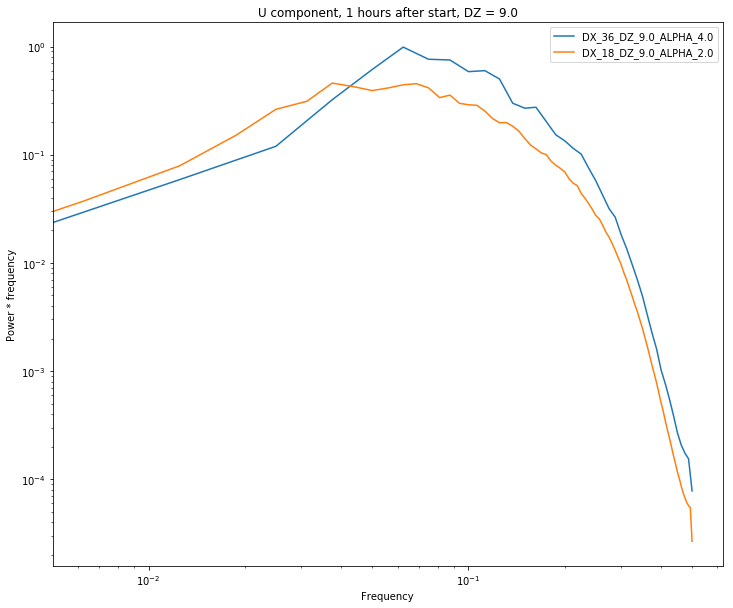

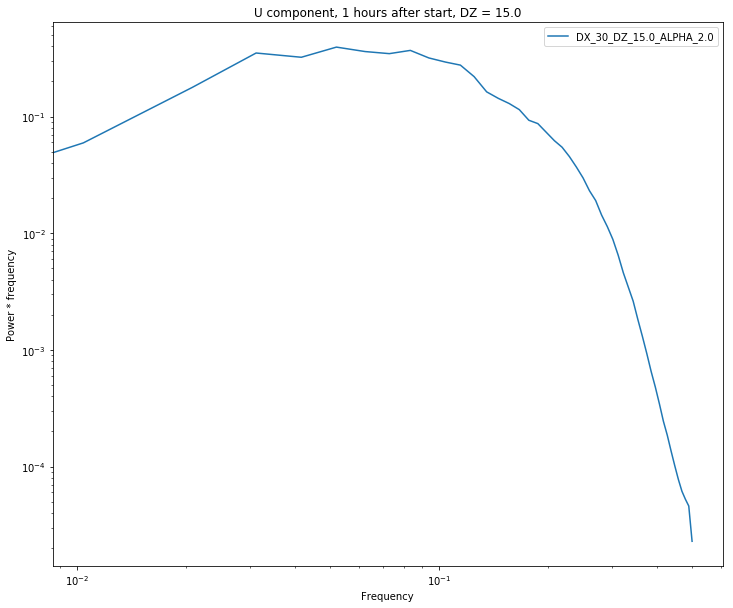

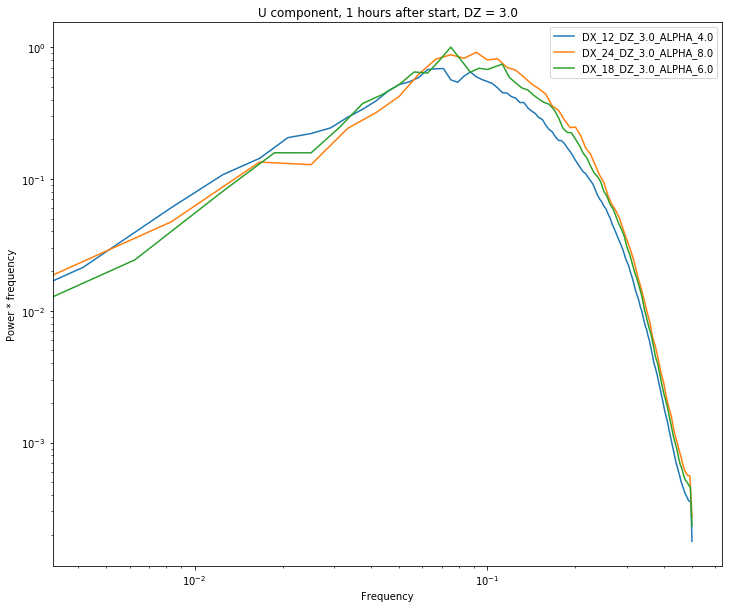

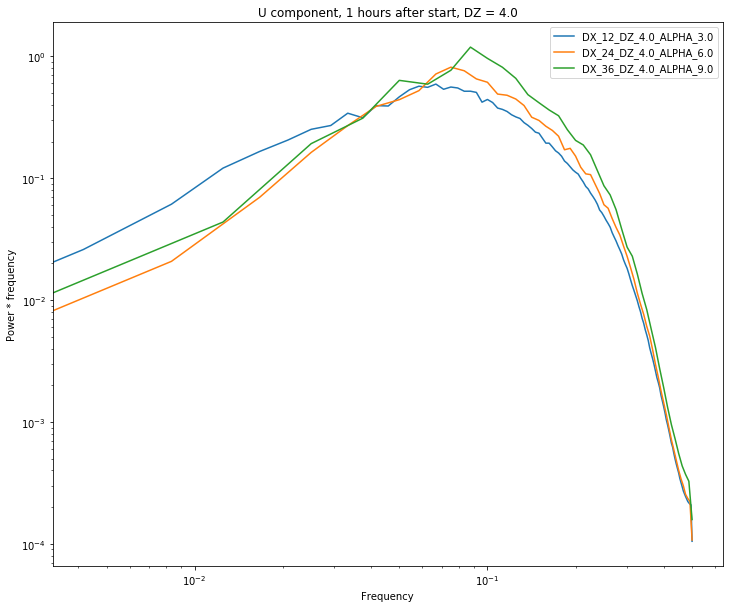

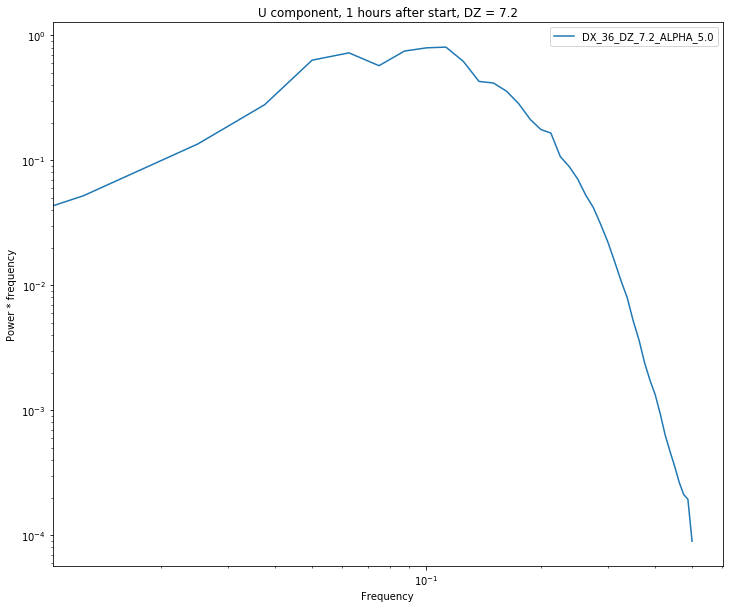

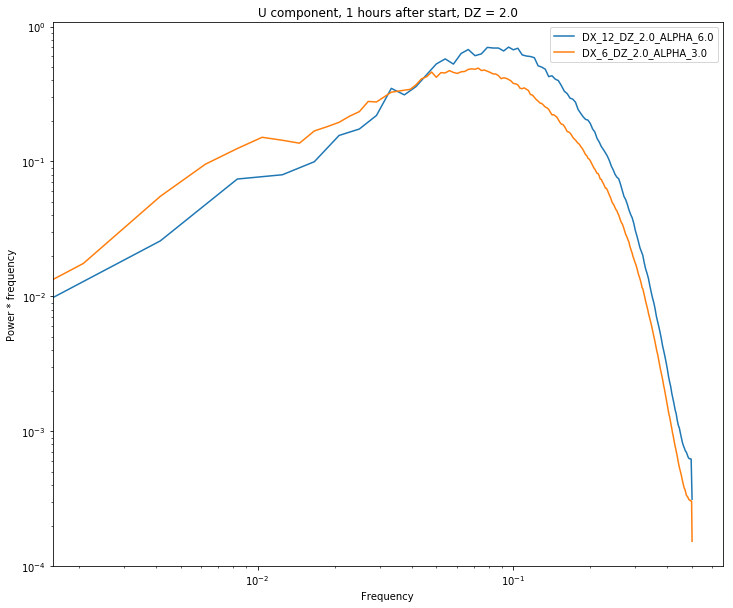

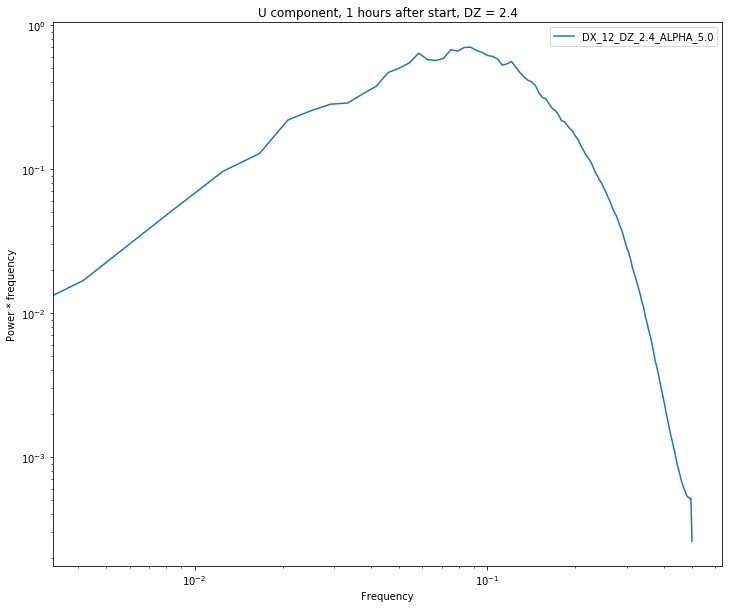

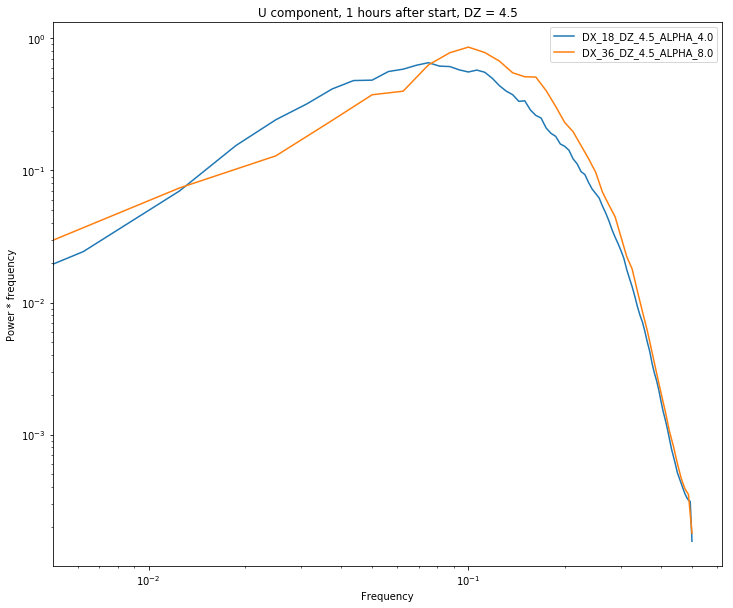

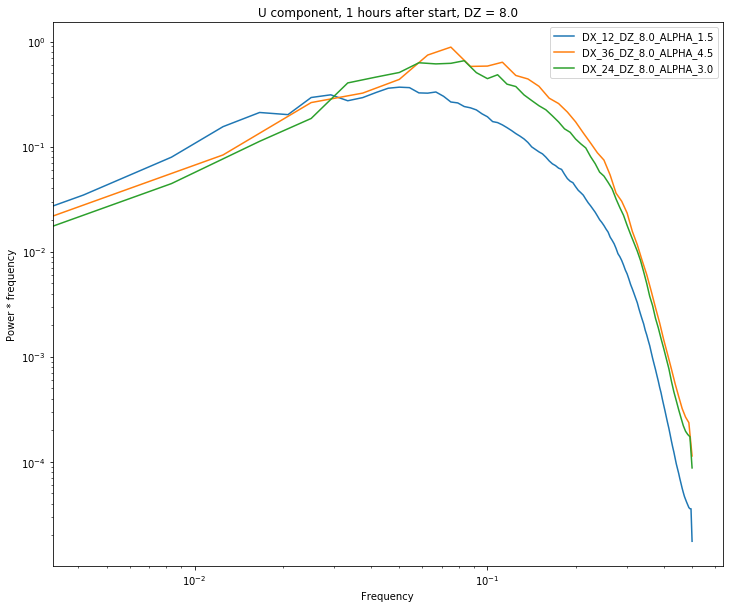

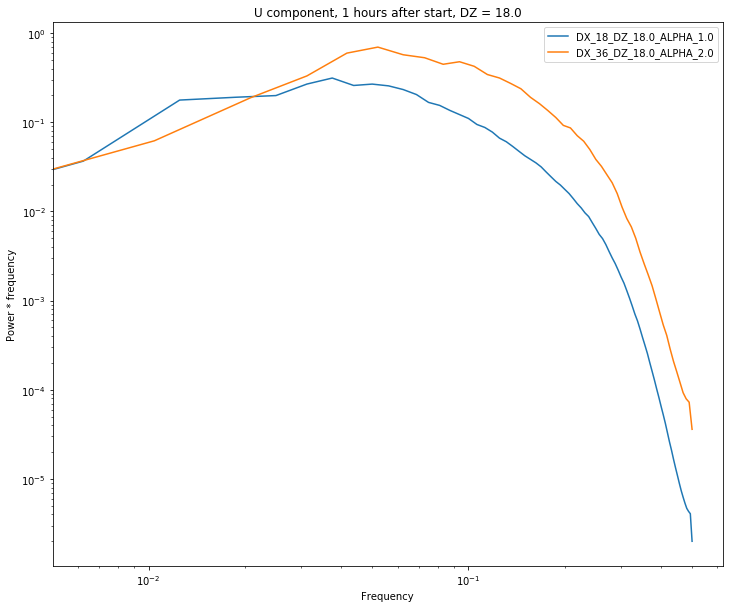

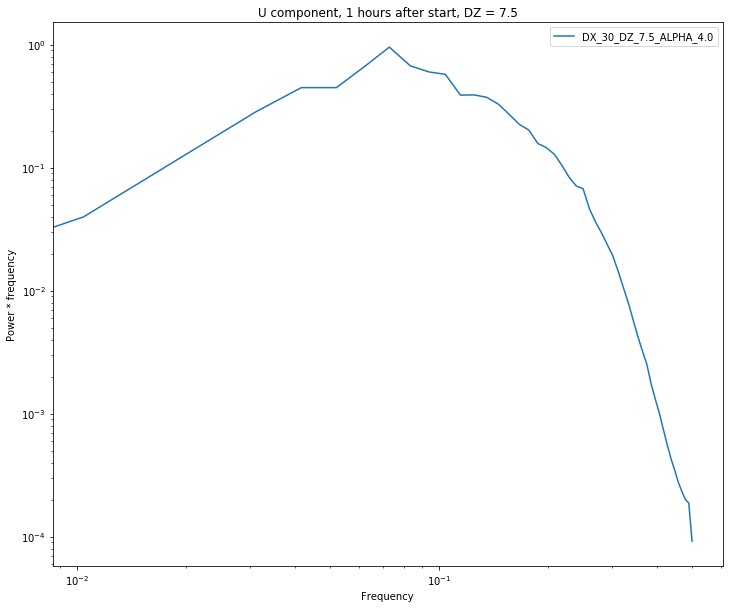

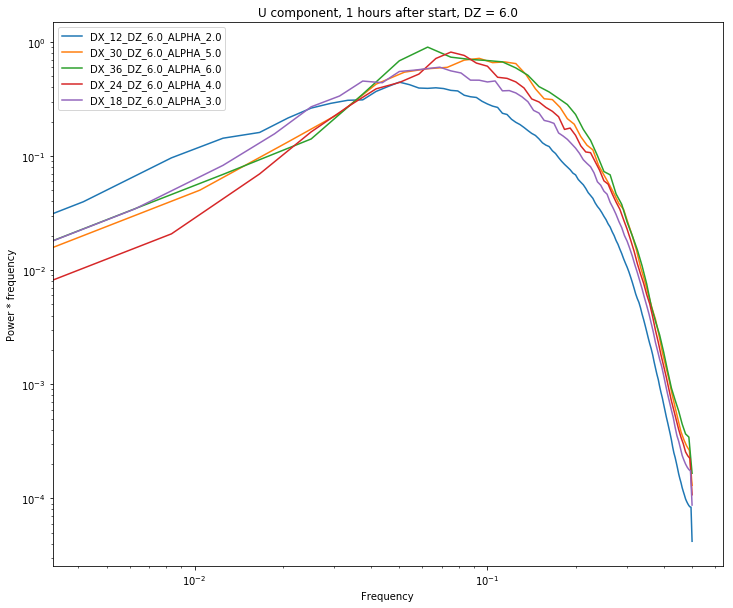

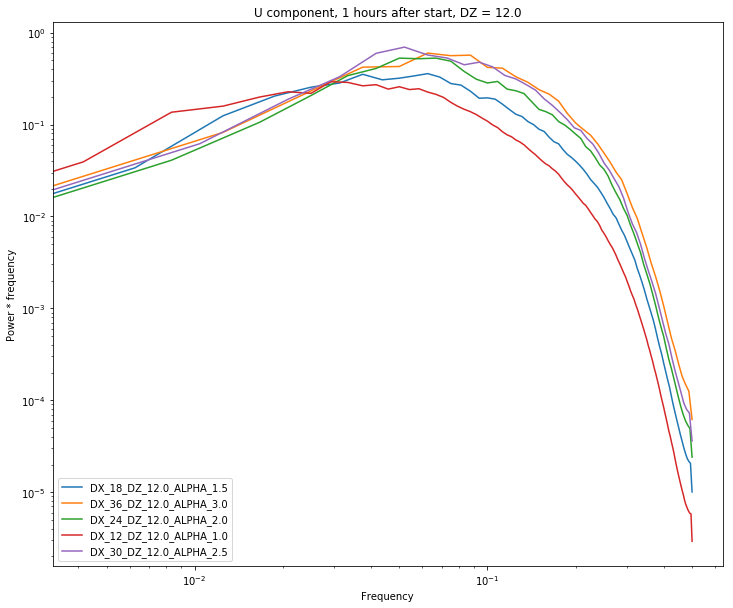

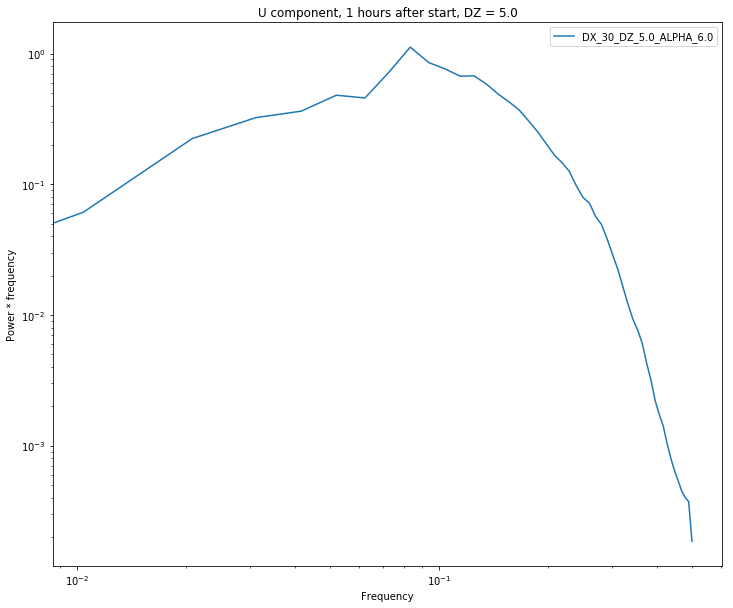

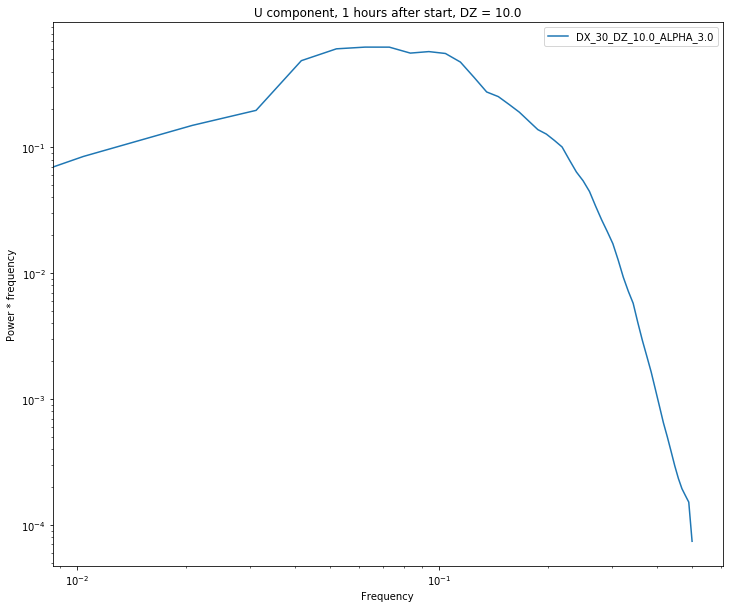

In [34]:
#Spectra after one hour a function of cases
for dz_unique in DZ_unique:
    plt.figure( figsize = (12, 10) )
    tind = 1

    z_spectra=0 #first level

    for tt in range(0, len(cases)):
        DX = cases[tt].split('_')[1]
        DZ = cases[tt].split('_')[3]
        
        if DZ == dz_unique:
            z_spectra = psd_ds_1hr[tt].z.isel(XTIME = 0)
            psd_ds_1hr[tt]['U_p_norm_power'] = psd_ds_1hr[tt].U_p * psd_ds_1hr[tt].frequency
            psd_ds_1hr[tt]['W_p_norm_power'] = psd_ds_1hr[tt].W_p * psd_ds_1hr[tt].frequency
            plt.plot( psd_ds_1hr[tt].frequency, psd_ds_1hr[tt].U_p_norm_power.isel(XTIME = 0, nz = 0),\
                    label = f'{cases[tt]}' )

    plt.ylabel('Power * frequency')    
    plt.xlabel('Frequency')

    plt.title(f"U component, {tind} hours after start, DZ = {dz_unique}")

    plt.xscale('log')
    plt.yscale('log')

    plt.legend(loc = 'best')